In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
# import swifter
import gc
import timeit
# from numba import jit, cuda
from Bio import SeqIO
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectPercentile, chi2, SelectFromModel,SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, plot_roc_curve
from sklearn.metrics import plot_confusion_matrix,roc_auc_score,roc_curve,confusion_matrix
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from scipy import sparse
import seaborn as sn
from joblib import dump, load
import multiprocessing as mp
import time
%matplotlib inline
import pickle
from tqdm.auto import tqdm

from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
tqdm.pandas()
import plotly as pty
from ipywidgets import IntProgress

import time
from IPython import display
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve


In [75]:
def select_features(X,y,nb,indices):
#     X_selected = X[feat_importances_columns]
    X_selected=X.iloc[:,indices[:nb]]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.1, random_state=42, stratify=y)
    return X_train, X_test,y_train, y_test
def searchBestNumber(xmin, xmax, step, X, y, indices):

        # lists to store values of performance measures. used to plot later
    acc=[]
    pre=[]
    rec=[]
    auc=[]
    f=[]
    # x is used to store the iteration number
    x=[]

    for i in range(xmin,xmax,step):
        fig, ax = plt.subplots(figsize=(22,9))

        X_train, X_test, y_train, y_test = select_features(X,y,i,indices)
        classifier = RandomForestClassifier(random_state=10,verbose=0,n_jobs=-1)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        y_prob = classifier.predict_proba(X_test)[:, 1]
        accuracy, precision, recall, f1, aucs= get_metrics(y_test, y_pred,y_prob)
        print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f \nAUC score = %.3f" % 
              (accuracy, precision, recall, f1,aucs))
        print("-----------------------------------------------------------------------\n")

        x.append(i)
        acc.append(accuracy)
        pre.append(precision)
        rec.append(recall)
        f.append(f1)
        auc.append(aucs)

    #     plt.xticks(x)
    #     plt.yticks(y)

        prep = plt.plot(x,pre, label="Precision", marker='o', color='orange')
        f1p = plt.plot(x,f,label="F1-score", marker='o', color='r')
        accp = plt.plot(x,acc, label="Accuracy", marker='o',color='b') 
        recp = plt.plot(x,rec,label="Recall", marker='o', color='g')
        aucp = plt.plot(x,auc,label="AUC score", marker='o', color='black')



    #     plt.legend([accp, prep,recp,f1p])#, ['Acuuracy', 'Precision', 'Recall', 'F1-score'])

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels)
        plt.xlabel("Number of Features")
        plt.title("Performance versus Nb of Features")
        display.clear_output(wait=True)
        plt.show()

    #Get the index of best performances    
    print("Highest Accuracy: ",max(acc))
    # calculate index of the highest accuracy, precision, recall, f1 and auc score, 
    # values depending on the size of step defined above
    bestNumber = acc.index(max(acc))*step+xmin
    print("Index of highest Accuracy  ",bestNumber)

    print("Highest Precision: ",max(pre))
    bestNumber = pre.index(max(pre))*step+xmin
    print("Nb of features  of highest Precision ",bestNumber)

    print("Highest Recall: ",max(rec))
    bestNumber = rec.index(max(rec))*step+xmin
    print("Nb of features  of highest Recall    ",bestNumber)

    print("Highest F1: ",max(f))
    bestNumber = f.index(max(f))*step+xmin
    print("Nb of features  of highest F1        ",bestNumber)

    print("Highest AUC score: ",max(auc))
    bestNumber = auc.index(max(auc))*step+xmin
    print("Nb of features of highest AUC score ",bestNumber)
    
    return bestNumber



        
def get_metrics(y_test, y_predicted, y_prob):
            accuracy = accuracy_score(y_test, y_predicted)
            precision = precision_score(y_test, y_predicted, average='weighted')
            recall = recall_score(y_test, y_predicted, average='weighted')
            f1 = f1_score(y_test, y_predicted, average='weighted')
            auc= roc_auc_score(y_test, y_prob)
            return accuracy, precision, recall, f1, auc
        
def benchmarkAlgos(X, y):
    # ind is the index of the number of features with highest performance

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


    classifiers = {
        'RandomForestClassifier': RandomForestClassifier(random_state=10,verbose=0,n_jobs=-1),
        'LogisticRegression': LogisticRegression(verbose=0,n_jobs=-1),
        'SGDClassifier': SGDClassifier(average=100,verbose=0, n_jobs=-1),
    }
    for name, classifier in classifiers.items():
        start = time.time()
        classifier.fit(X_train, y_train)
        end = time.time()

        plot_roc_curve(classifier,X_test,y_test, pos_label='0')

        # total time taken
        print(f"Runtime of ",name, f" training is {end - start} secs")


        y_pred = classifier.predict(X_test)
        print("Perf Results for ", name, " : \n -------------------------------------")

    #   SGDclassifier does not have predict_proba  method
        if (name!='SGDClassifier'):
            y_prob = classifier.predict_proba(X_test)[:, 1]

        accuracy, precision, recall, f1, auc = get_metrics(y_test, y_pred,y_prob)
        print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f \nAUC score = %.3f" % (accuracy, precision, recall, f1,auc))
        print("-----------------------------------------------------------------------\n")

def embeddedSelect(X,y):
    clf = RandomForestClassifier(random_state=10,verbose=1, n_jobs=-1).fit(X,y)

    # print("score {:.3f}".format(score))
    # rank the features
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]#[::-1] is to reverse the array

    n_features = X.shape[1]
    # get the features sorted by decreasing importance
    feat_importances_sorted = [(indices[f], importances[indices[f]]) for f in range(n_features)]
    print("number of features:  ", len(X.columns))
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 16}

    matplotlib.rc('font', **font)
    figure, axes = plt.subplots(1, 2,figsize=(22,12))
    feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    feat_importances.nlargest(30).plot(ax=axes[0],kind='pie', normalize=True, title='Features importances')
    feat_importances.nlargest(50).plot(ax=axes[1],kind='barh', title='  Features importances')
    return indices



# Import Labels

In [3]:
y = []
def importLabels():
#     with open('./Data/shortlabels.txt', 'r') as filehandle:
    with open('D:/DataSet/Data/labels.txt', 'r') as filehandle:


        for line in filehandle:
            # remove linebreak, if exists, which is the last character of the string
            if(line[-1] == "\n"):
                currentPlace = line[:-1]
            else:
                currentPlace = line[:]
            # add item to the list
            y.append(currentPlace)
importLabels()


# Step 0: only run once, later load from disk
## Read BoW data, Apply filter method and save feature-selected dataset to disk
## Here we select the best 100 features and write them to disk for each dataset k=5,6,7 

In [3]:

# for k in range(5,8):
#     print(k)
#     X = pd.read_feather(r"D:\DataSet\TfIdf\dfk"+str(k)+".feather")
#     # define feature selection
#     fs = SelectKBest(score_func=f_classif, k=100)
#     # apply feature selection
#     X_import = fs.fit_transform(X, y)

#     cols = fs.get_support(indices=True)
#     X_import = X.iloc[:,cols]
#     X_import.to_feather(r"D:\DataSet\TfIdf\100-f_classif-Selected-k"+str(k)+".feather")
#     X_import

# Step 1
## 1.1 Load from disk the 3x100 best selected of Step 0

In [24]:
k1=5
k2=6
k3=7

X1 = pd.read_feather(r"D:\DataSet\TfIdf\100-f_classif-Selected-k"+str(k1)+".feather")
X2 = pd.read_feather(r"D:\DataSet\TfIdf\100-f_classif-Selected-k"+str(k2)+".feather")
X3 = pd.read_feather(r"D:\DataSet\TfIdf\100-f_classif-Selected-k"+str(k3)+".feather")
xt = pd.concat((X1, X2), axis=1)
X_import =pd.concat((xt, X3), axis=1)
cols=X_import.columns
from sklearn.feature_extraction.text import TfidfTransformer
t = TfidfTransformer().fit(X_import).transform(X_import).toarray()
X = pd.DataFrame(t, columns=cols)
print(X.shape)



(60000, 300)


##  1.2 Apply Filter method on aggregated 300 features dataset

<AxesSubplot:title={'center':'K=5 6 7 Features importances'}>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


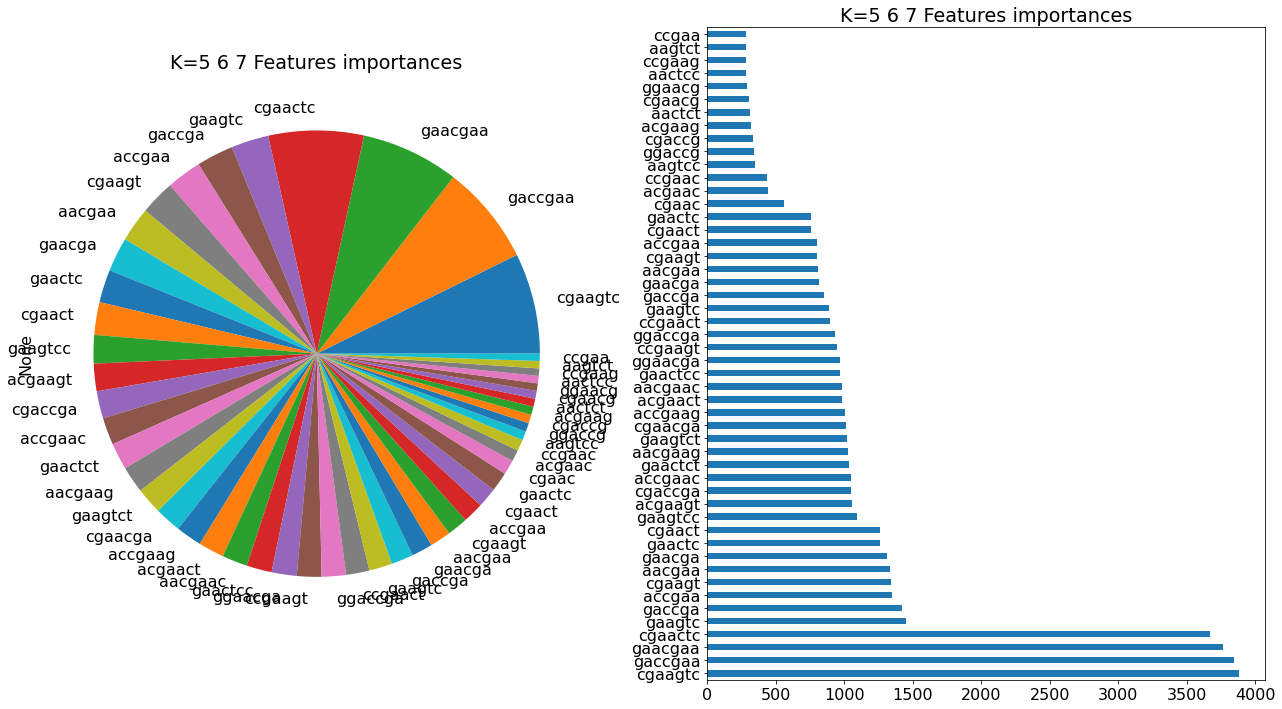

In [7]:
# Define font size
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)
fs = SelectKBest(score_func=f_classif, k=300)
# apply feature selection
X_best = fs.fit_transform(X, y)
cols = fs.get_support(indices=True)
feat_importances = pd.Series(fs.scores_, index=cols).to_frame().T
indices = np.argsort(feat_importances).values[0][::-1]#[::-1] is to reverse the array

###################################################################
# Dataset with features reordered according to importanceto pass to second step 
##################################################################
# X.iloc[:,indices]
##################################################################

figure, axes = plt.subplots(1, 2,figsize=(22,12))
fi_plot = pd.Series(fs.scores_, index=X.columns)
# ind = np.argsort(fi_plot)[::-1]#[::-1] is to reverse the array

feat_importances_columns =fi_plot[indices].to_frame().T.columns

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
fi_plot.nlargest(50).plot(ax=axes[0],kind='pie', normalize=True, title='K='+str(k1)+" "+str(k2)+" "+str(k3)+' Features importances')
fi_plot.nlargest(50).plot(ax=axes[1],kind='barh', title='K='+str(k1)+" "+str(k2)+" "+str(k3)+' Features importances')

## 1.3 Use Search method to Decide on the best number of features from selected ones
Plot in Real-Time scores to get best number of features after filter based selection

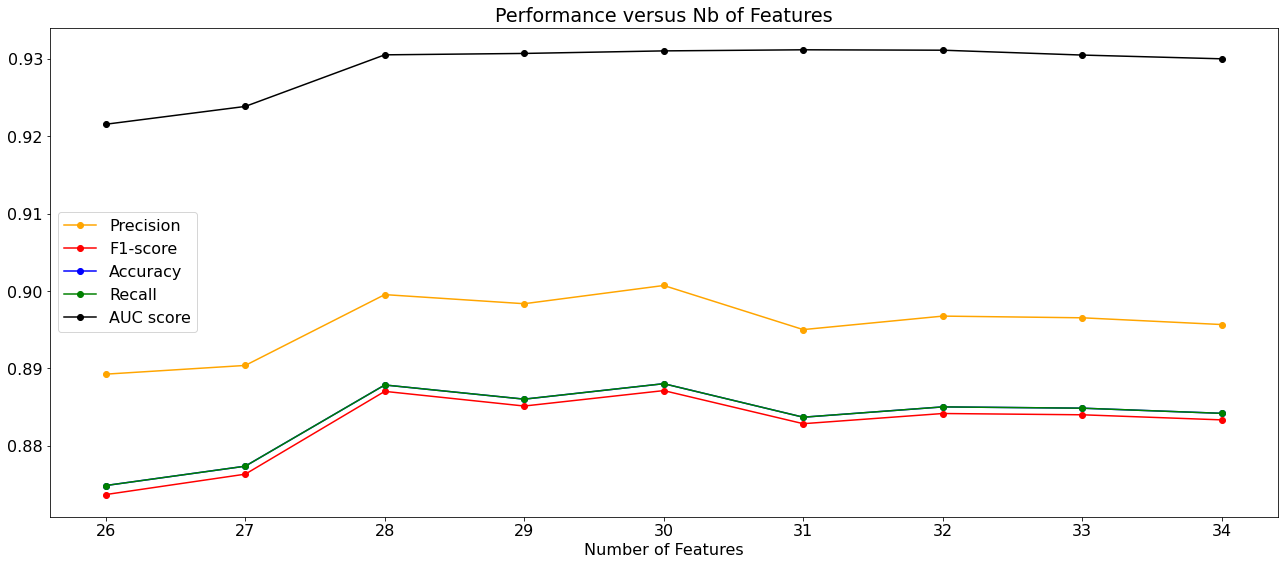

Highest Accuracy:  0.888
Index of highest Accuracy   30
Highest Precision:  0.9006956406792824
Nb of features  of highest Precision  30
Highest Recall:  0.888
Nb of features  of highest Recall     30
Highest F1:  0.8871057647626852
Nb of features  of highest F1         30
Highest AUC score:  0.9311678888888889
Nb of features of highest AUC score  31


In [72]:

# set min nb of feat to start the search from
xmin=26
# set max nb of feat to stop the search at
xmax=35
# set step size
step=1
# call the search method
featBestNumber = searchBestNumber(xmin, xmax, step, X, y, indices)
#########################################################
# write to disk dataframe with best number of freatures
#########################################################

# X.iloc[:, indices[:ind]].to_feather(r"D:\DataSet\TfIdf\D2-best"+str(featBestNumber)+".feather")
    
#         print("nb features: " + str(i)+"\n")
#         print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))


## 1.4 Select best number of features, then add a margin of 50 features to allow further selection by Embedded method

In [44]:
X_for_embedded=X.iloc[:,indices[:featBestNumber+50]]
# X_for_embedded

## 1.5 Performance on three algos is benchmarked

Runtime of  RandomForestClassifier  training is 13.209511041641235 secs
Perf Results for  RandomForestClassifier  : 
 -------------------------------------
accuracy = 0.867 
precision = 0.876 
recall = 0.867 
f1 = 0.866 
AUC score = 0.919
-----------------------------------------------------------------------

Runtime of  LogisticRegression  training is 4.171912431716919 secs
Perf Results for  LogisticRegression  : 
 -------------------------------------
accuracy = 0.669 
precision = 0.669 
recall = 0.669 
f1 = 0.669 
AUC score = 0.735
-----------------------------------------------------------------------

Runtime of  SGDClassifier  training is 0.4045600891113281 secs
Perf Results for  SGDClassifier  : 
 -------------------------------------
accuracy = 0.652 
precision = 0.652 
recall = 0.652 
f1 = 0.652 
AUC score = 0.735
-----------------------------------------------------------------------



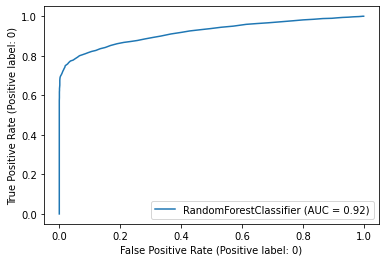

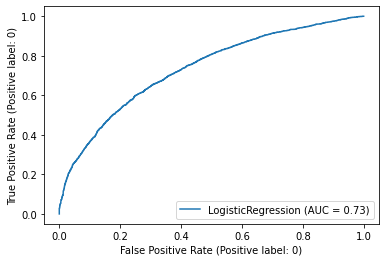

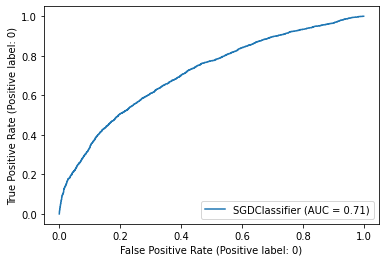

In [42]:
benchmarkAlgos(X_for_embedded, y)

# Step 2:  Embedded method

## 2.1 Select using RandomForest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.9s finished


number of features:   84


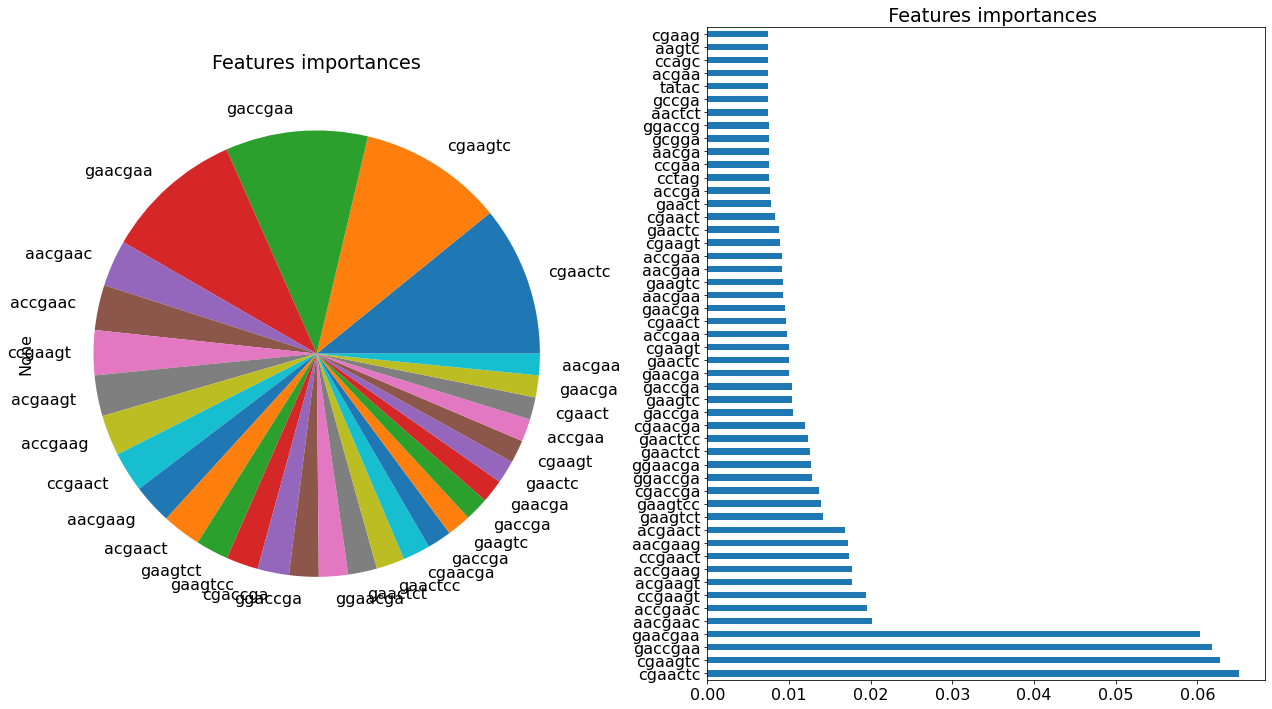

In [66]:
indices2 = embeddedSelect(X_for_embedded,y)

## 2.2 Decide on the best number of features second round
Plot in Real-Time scores to get best number of features after Embedded based selection

accuracy = 0.621 
precision = 0.623 
recall = 0.621 
f1 = 0.619 
AUC score = 0.637
-----------------------------------------------------------------------



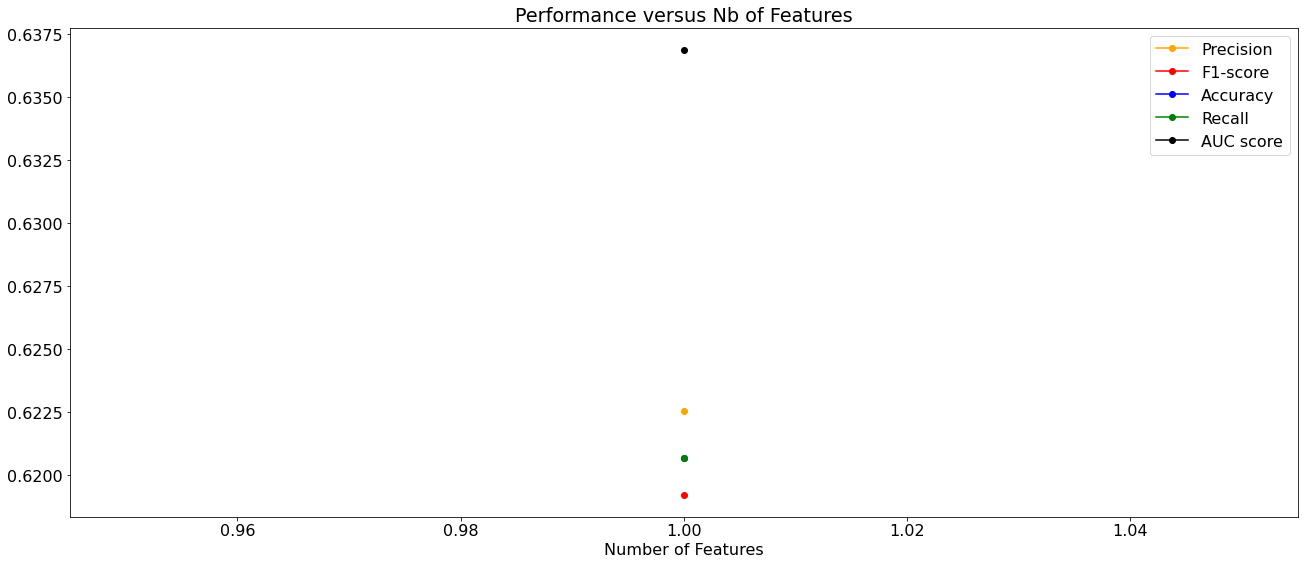

accuracy = 0.633 
precision = 0.633 
recall = 0.633 
f1 = 0.632 
AUC score = 0.698
-----------------------------------------------------------------------



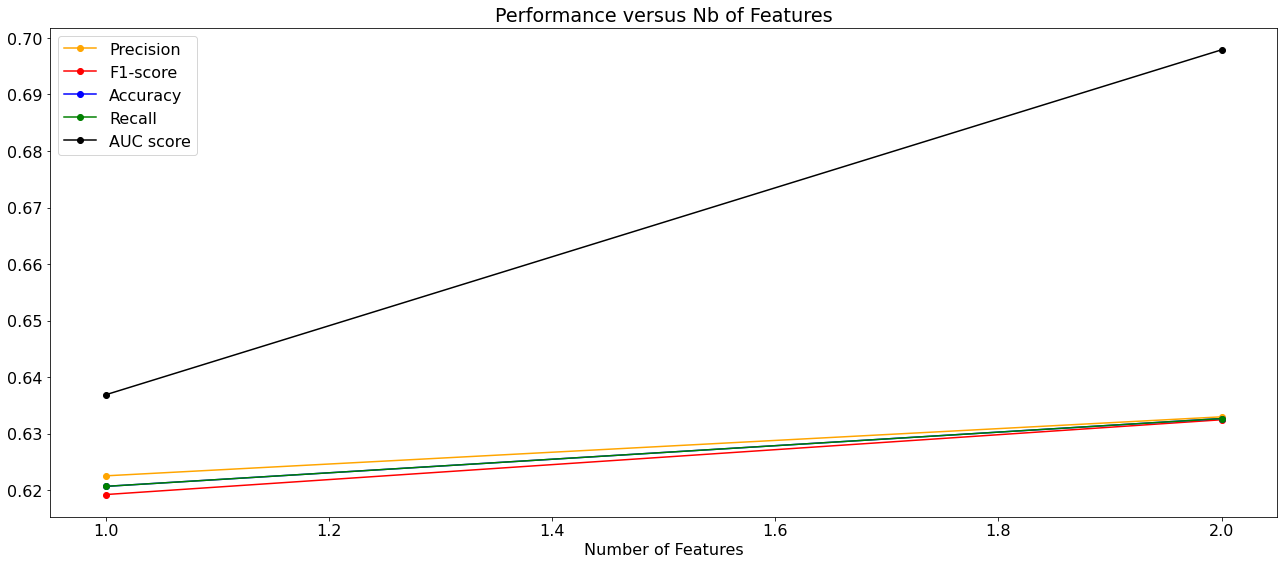

accuracy = 0.652 
precision = 0.653 
recall = 0.652 
f1 = 0.652 
AUC score = 0.733
-----------------------------------------------------------------------



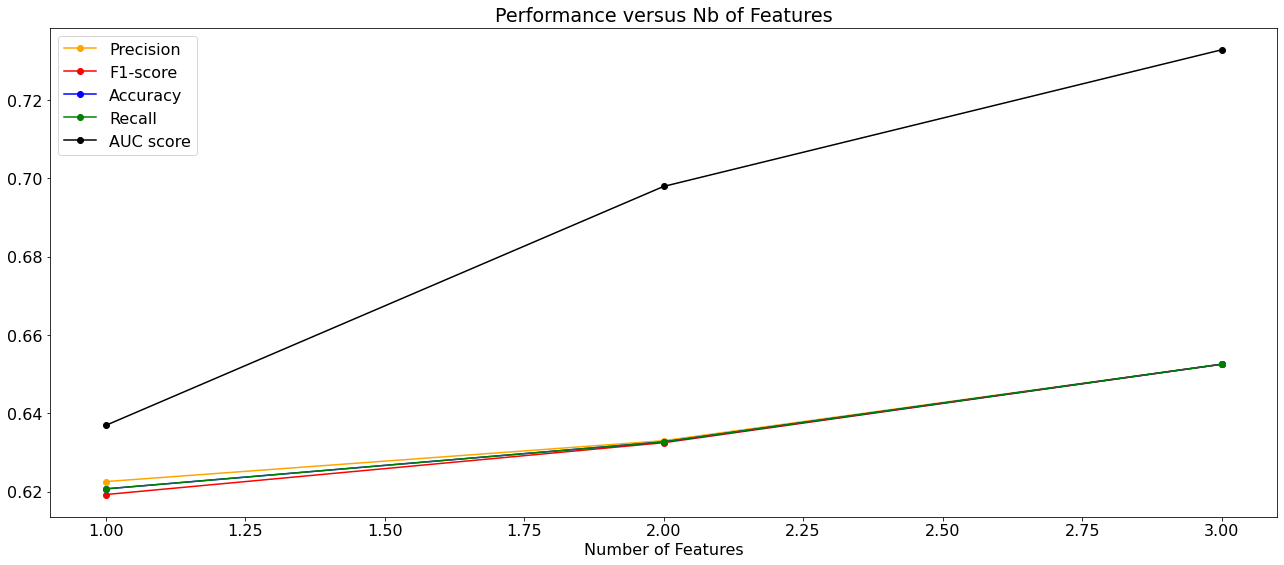

accuracy = 0.714 
precision = 0.714 
recall = 0.714 
f1 = 0.714 
AUC score = 0.799
-----------------------------------------------------------------------



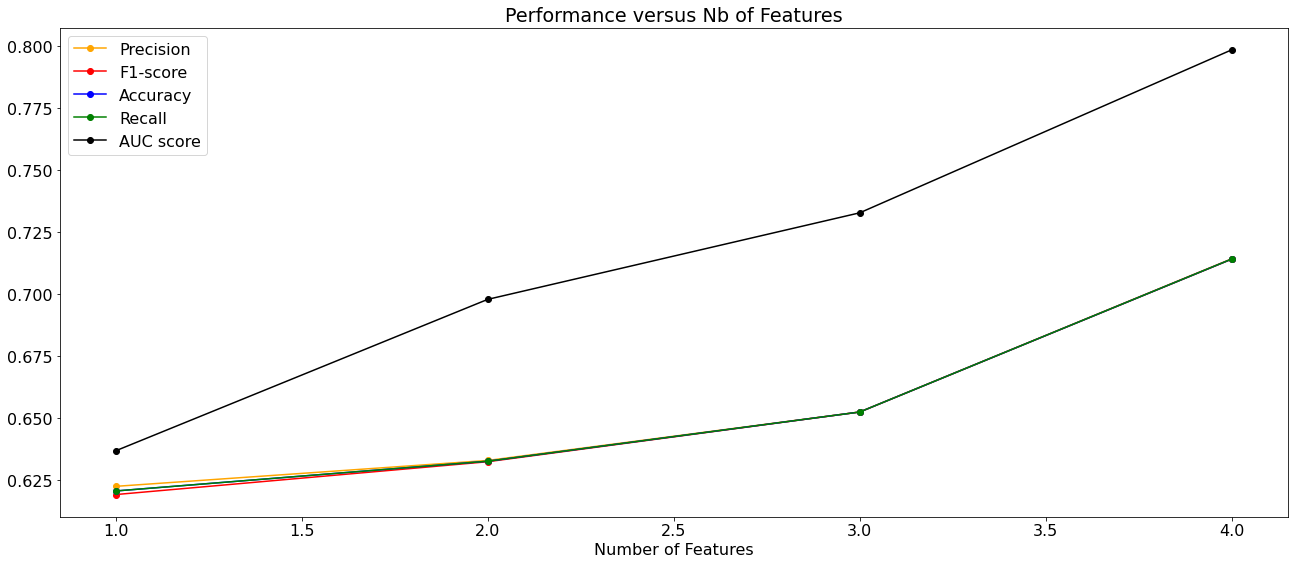

accuracy = 0.744 
precision = 0.746 
recall = 0.744 
f1 = 0.744 
AUC score = 0.818
-----------------------------------------------------------------------



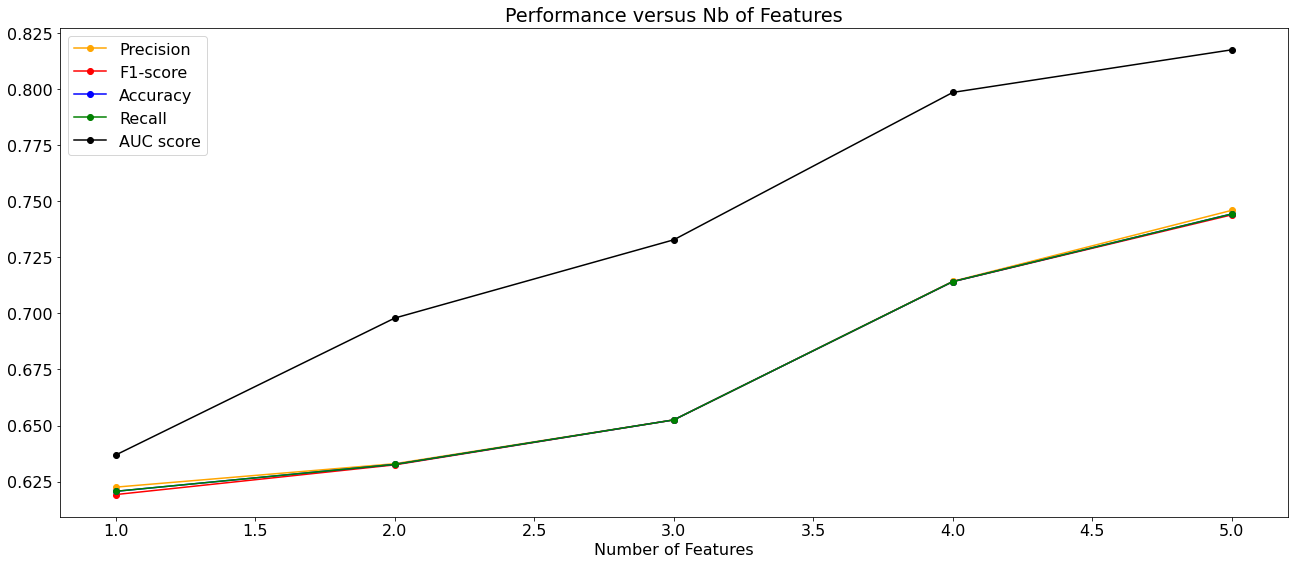

accuracy = 0.772 
precision = 0.776 
recall = 0.772 
f1 = 0.772 
AUC score = 0.839
-----------------------------------------------------------------------



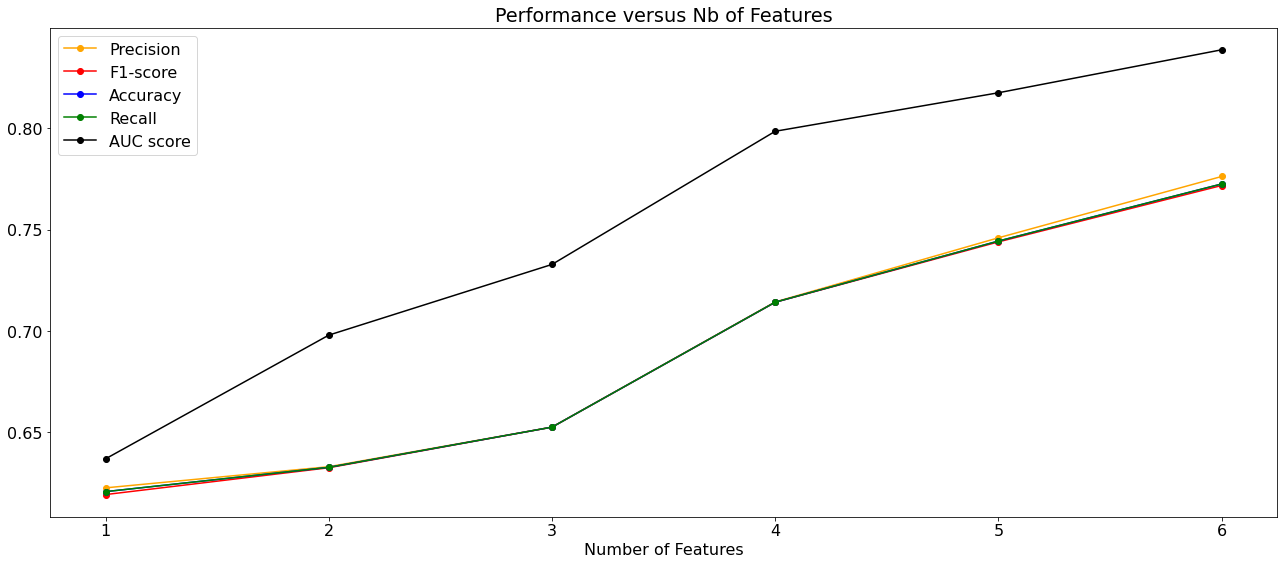

accuracy = 0.796 
precision = 0.803 
recall = 0.796 
f1 = 0.795 
AUC score = 0.857
-----------------------------------------------------------------------



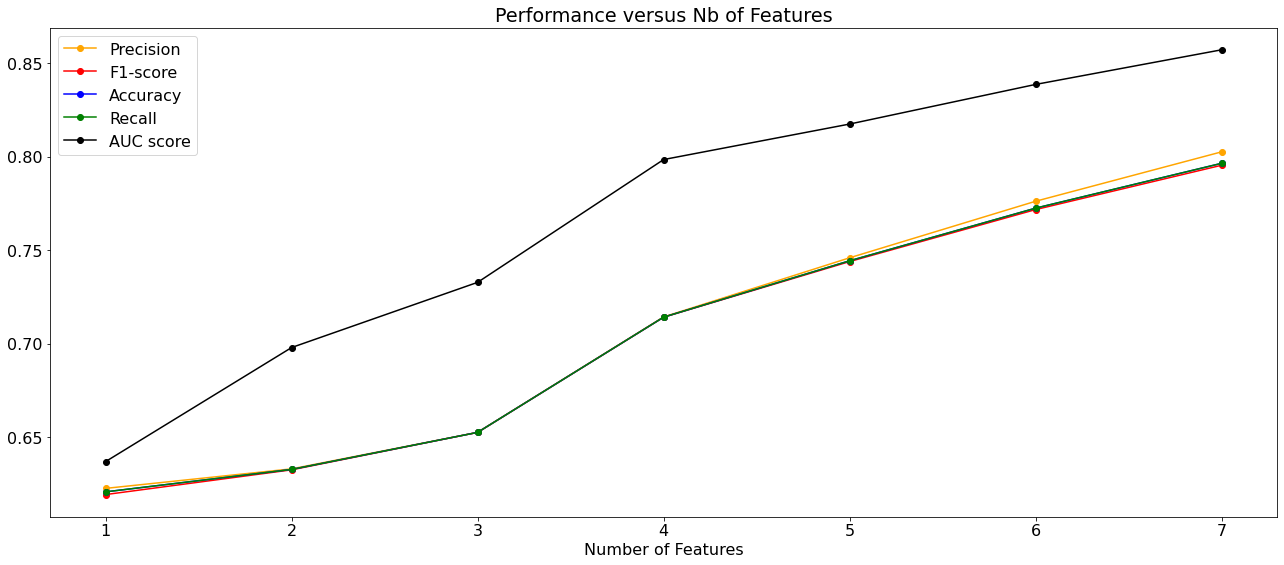

accuracy = 0.816 
precision = 0.826 
recall = 0.816 
f1 = 0.815 
AUC score = 0.870
-----------------------------------------------------------------------



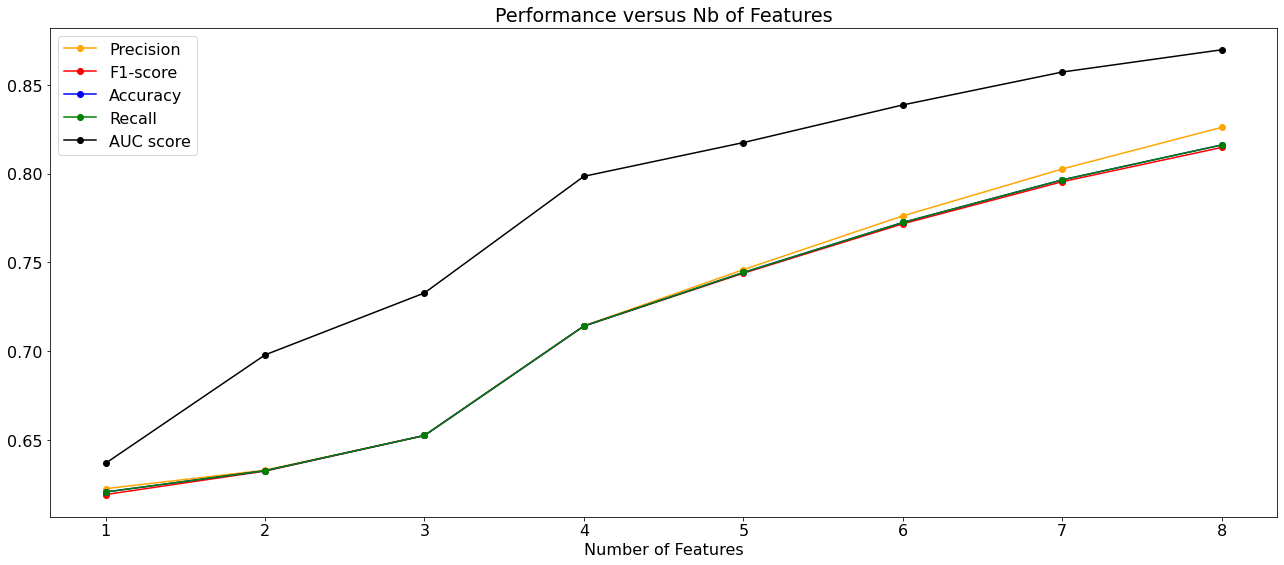

accuracy = 0.824 
precision = 0.835 
recall = 0.824 
f1 = 0.823 
AUC score = 0.879
-----------------------------------------------------------------------



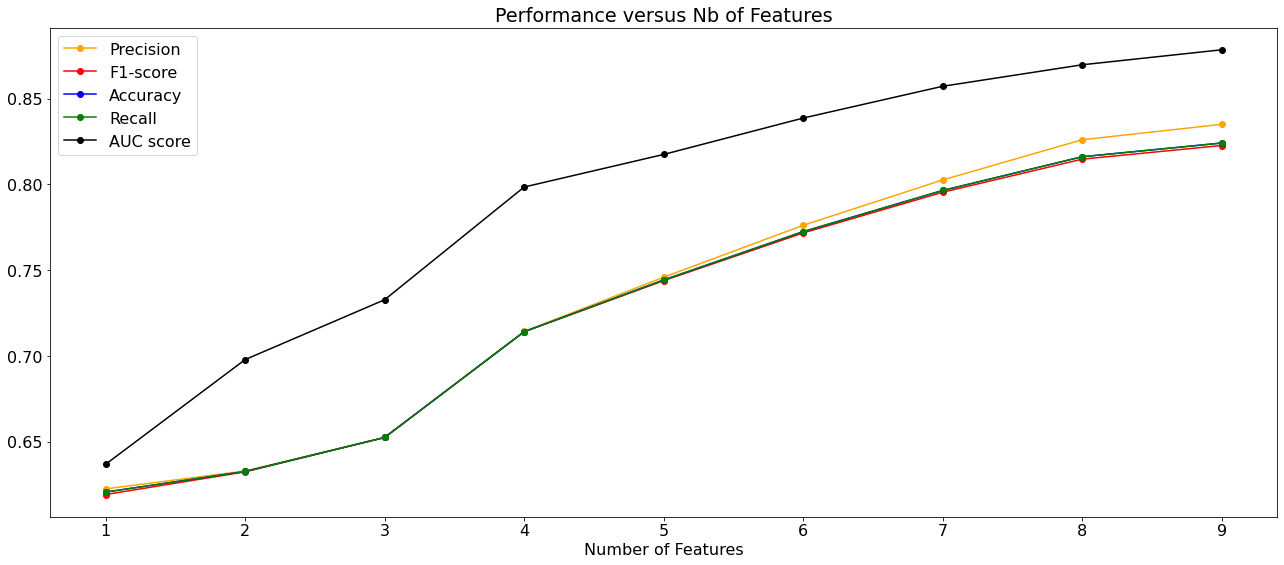

accuracy = 0.836 
precision = 0.848 
recall = 0.836 
f1 = 0.835 
AUC score = 0.889
-----------------------------------------------------------------------



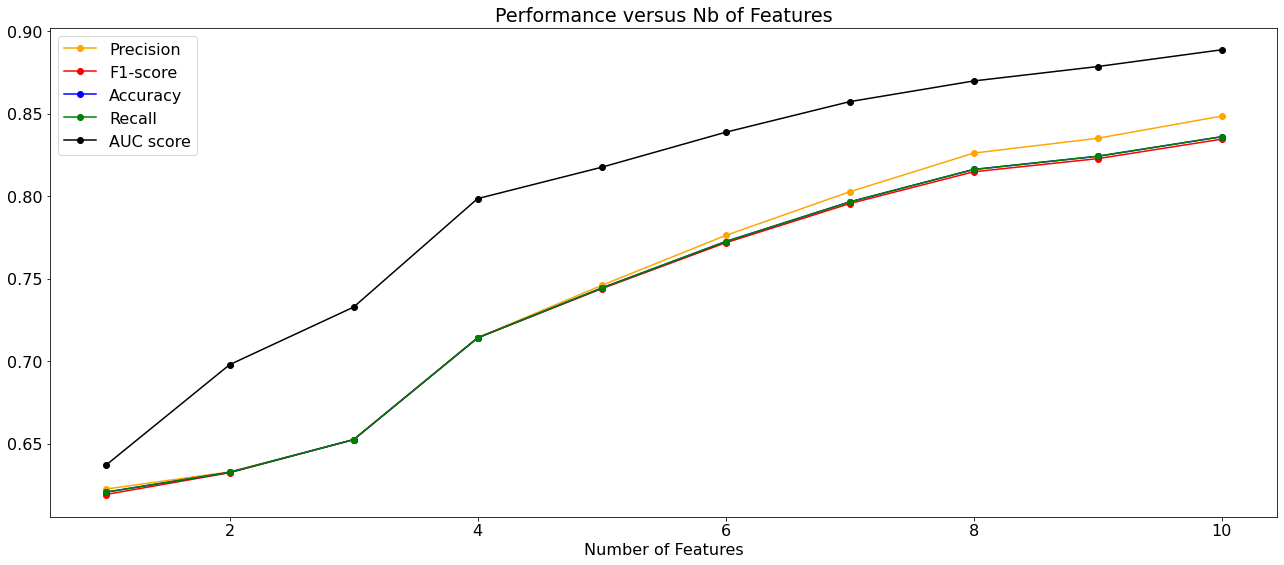

accuracy = 0.844 
precision = 0.858 
recall = 0.844 
f1 = 0.842 
AUC score = 0.896
-----------------------------------------------------------------------



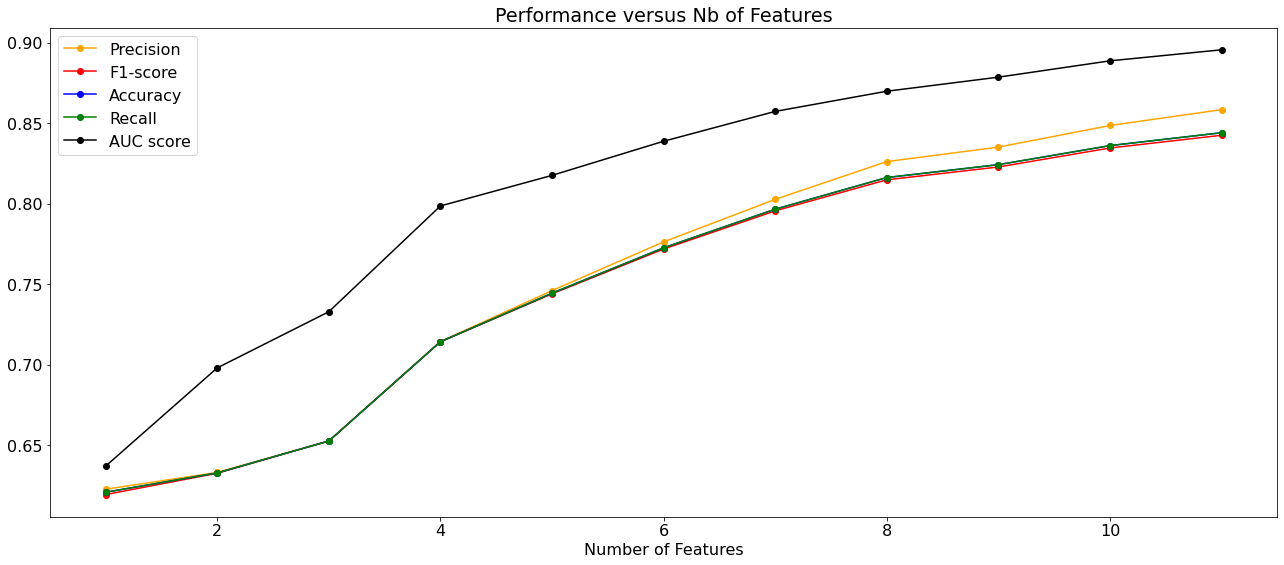

accuracy = 0.857 
precision = 0.873 
recall = 0.857 
f1 = 0.856 
AUC score = 0.905
-----------------------------------------------------------------------



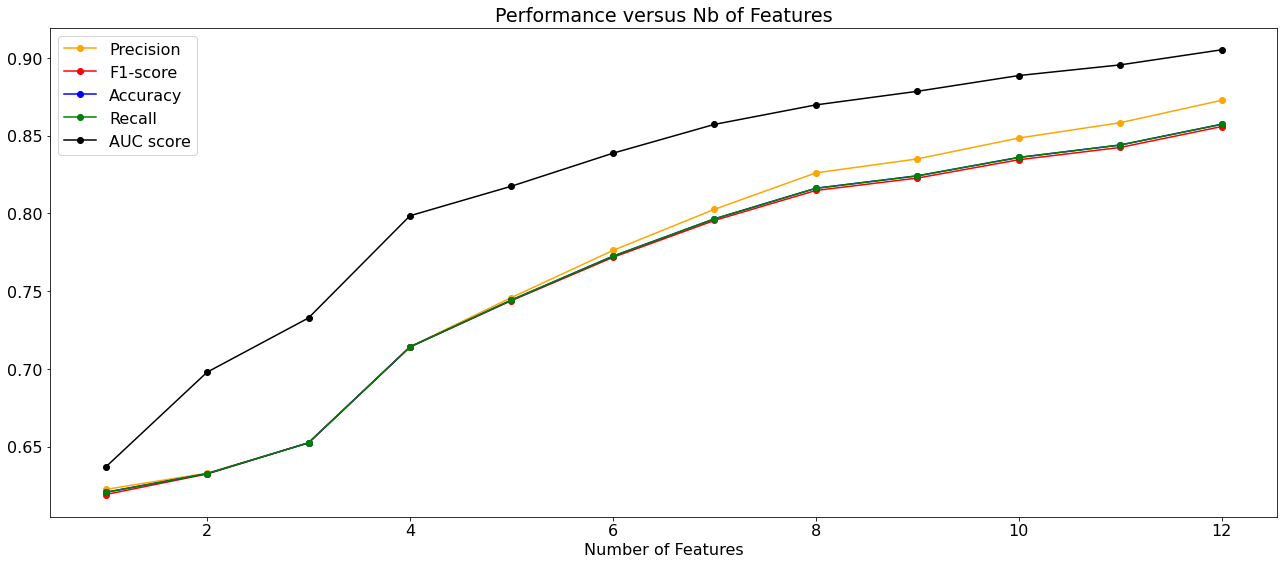

accuracy = 0.860 
precision = 0.876 
recall = 0.860 
f1 = 0.858 
AUC score = 0.907
-----------------------------------------------------------------------



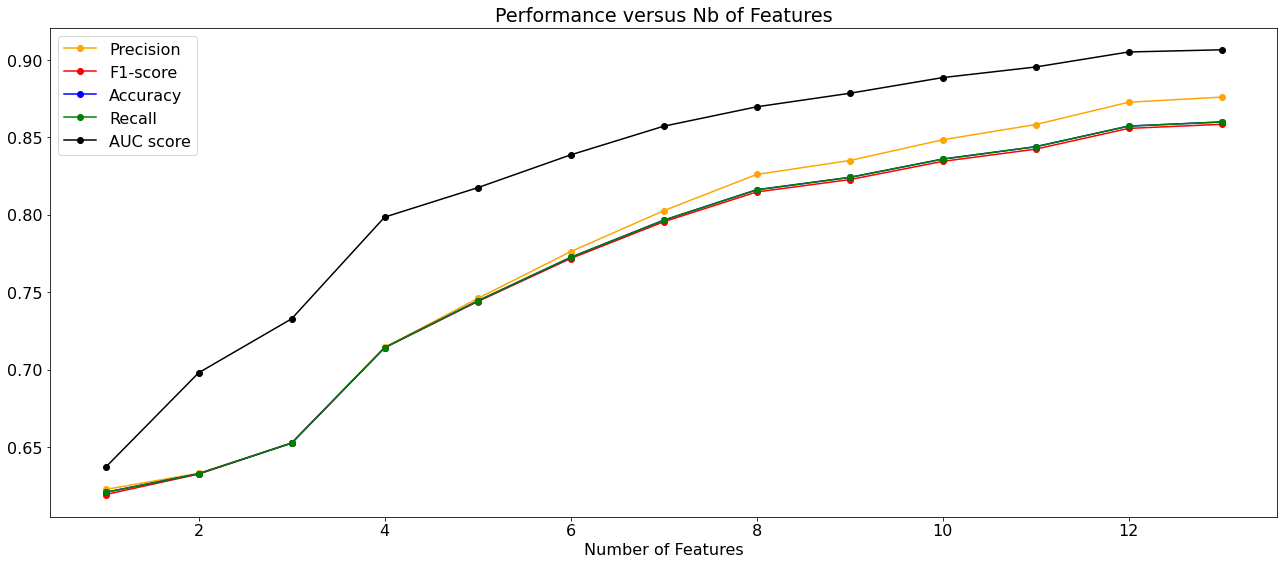

accuracy = 0.868 
precision = 0.884 
recall = 0.868 
f1 = 0.867 
AUC score = 0.912
-----------------------------------------------------------------------



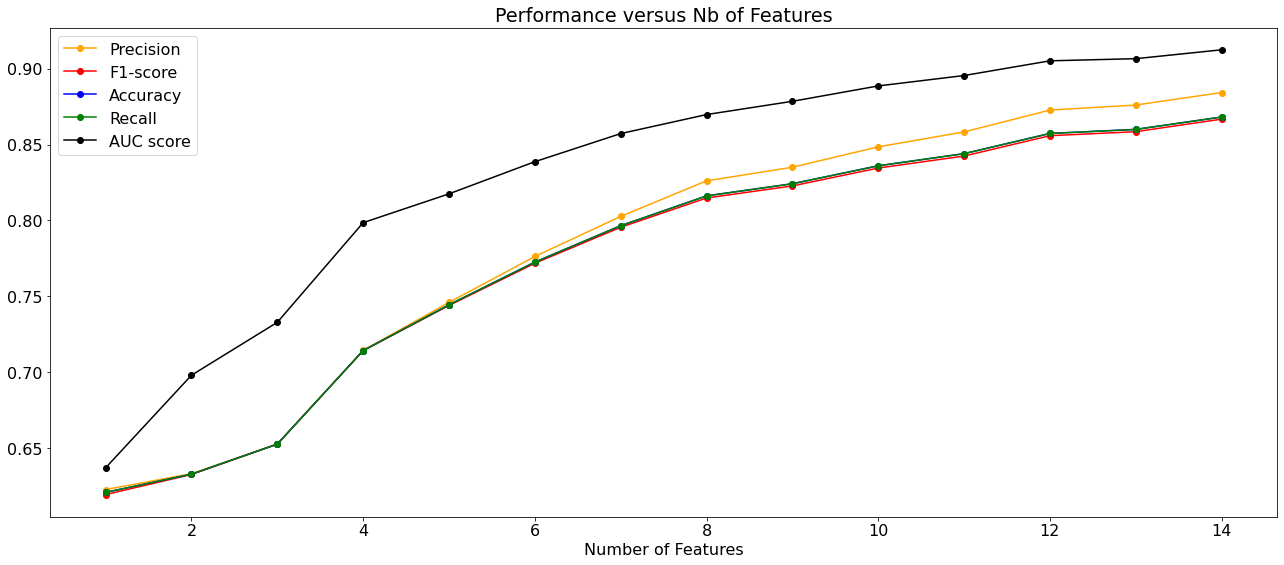

accuracy = 0.875 
precision = 0.890 
recall = 0.875 
f1 = 0.873 
AUC score = 0.914
-----------------------------------------------------------------------



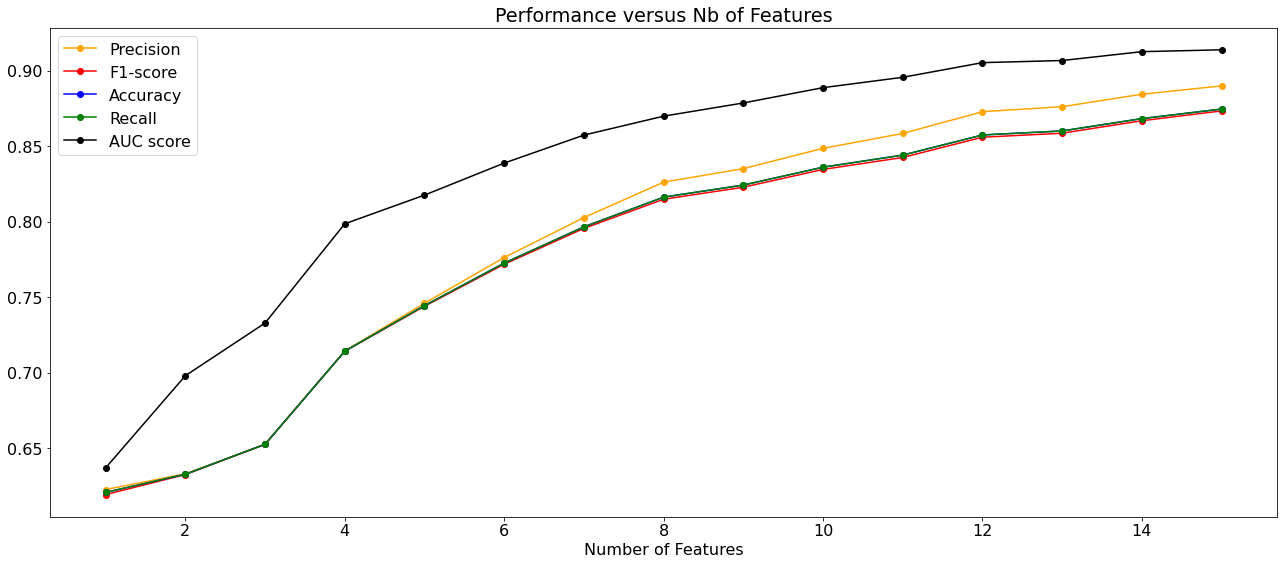

accuracy = 0.876 
precision = 0.890 
recall = 0.876 
f1 = 0.875 
AUC score = 0.917
-----------------------------------------------------------------------



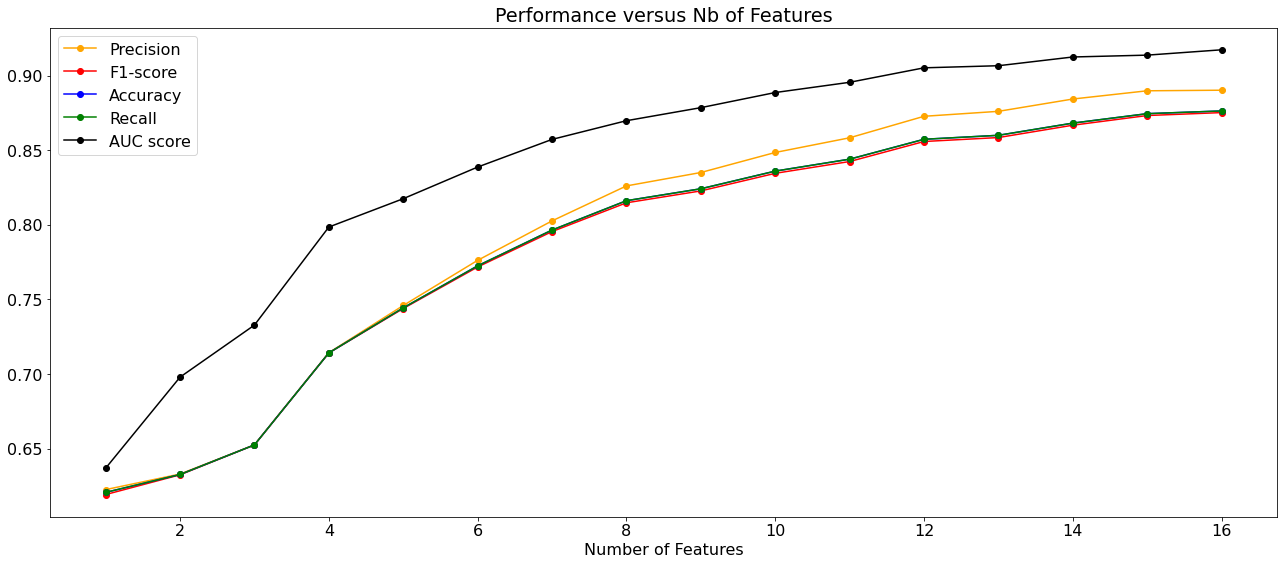

accuracy = 0.881 
precision = 0.896 
recall = 0.881 
f1 = 0.880 
AUC score = 0.921
-----------------------------------------------------------------------



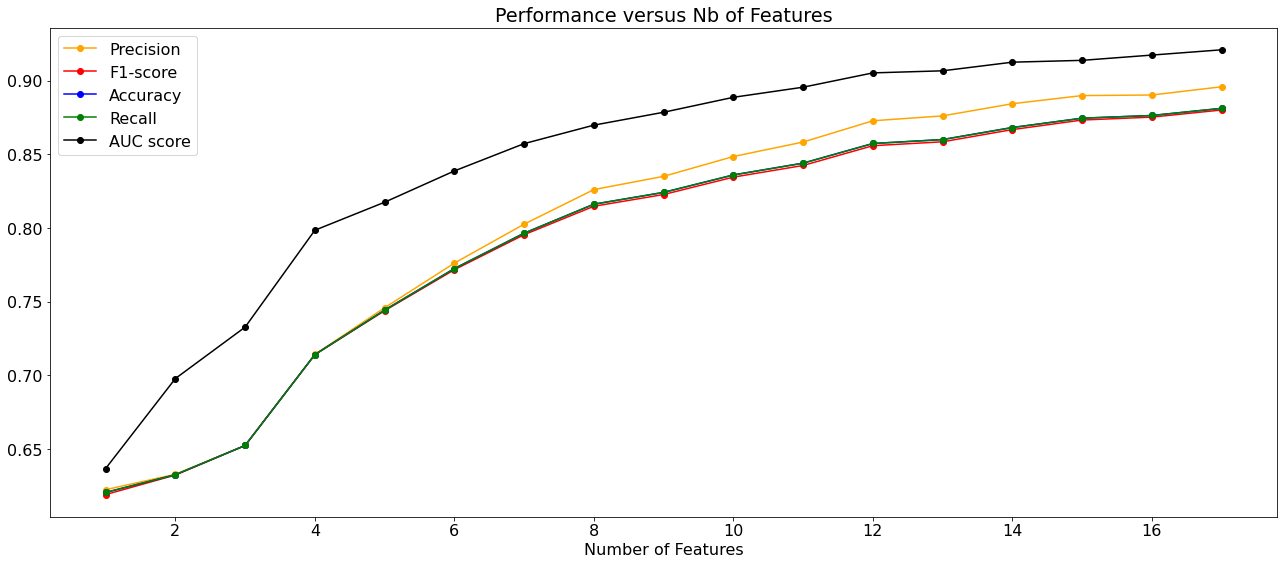

accuracy = 0.878 
precision = 0.892 
recall = 0.878 
f1 = 0.877 
AUC score = 0.924
-----------------------------------------------------------------------



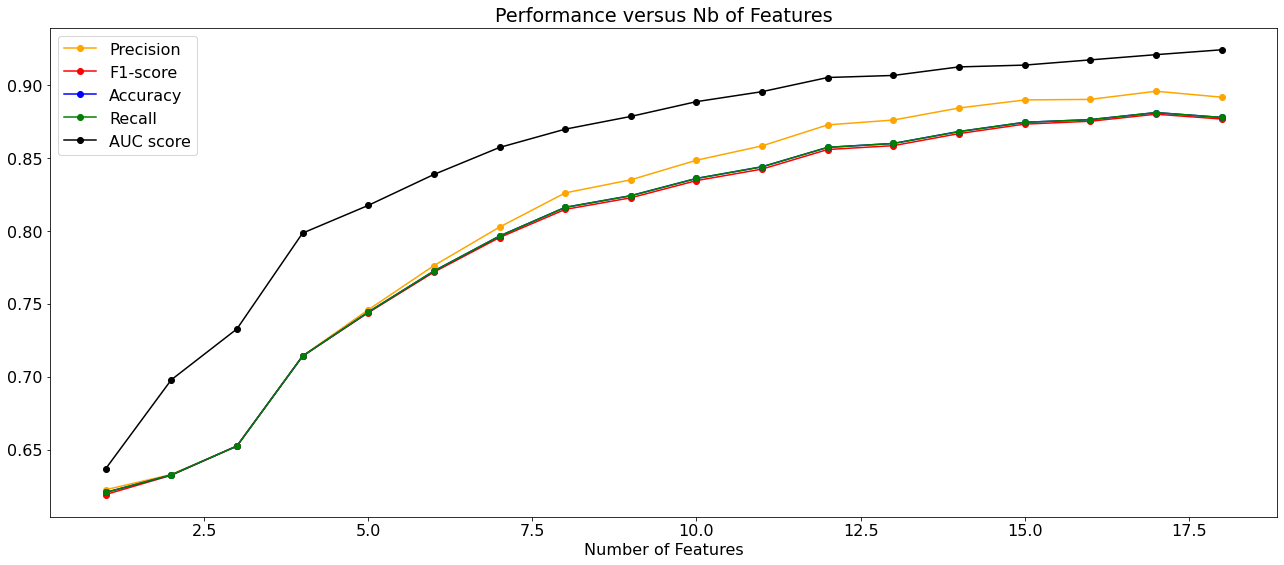

accuracy = 0.883 
precision = 0.895 
recall = 0.883 
f1 = 0.882 
AUC score = 0.926
-----------------------------------------------------------------------



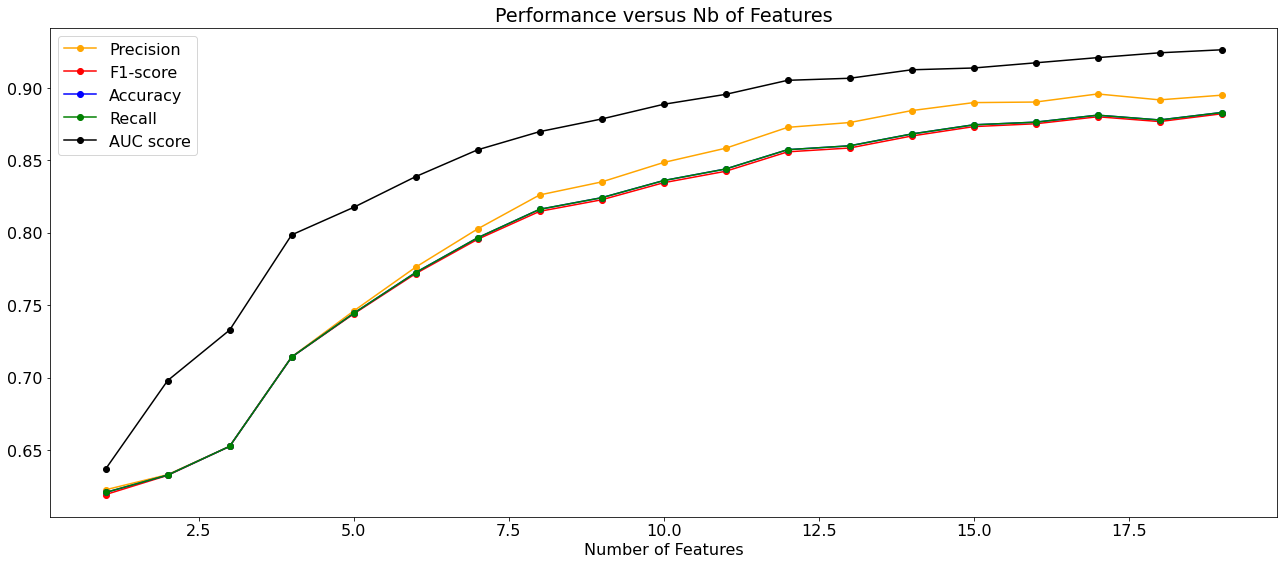

accuracy = 0.890 
precision = 0.902 
recall = 0.890 
f1 = 0.889 
AUC score = 0.932
-----------------------------------------------------------------------



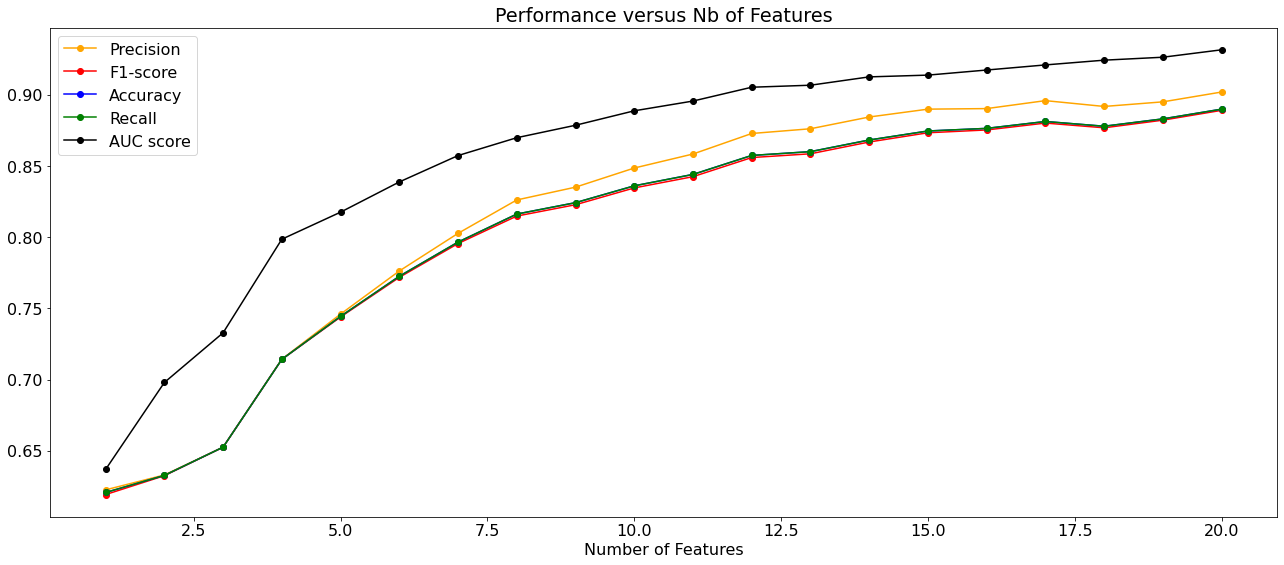

accuracy = 0.889 
precision = 0.901 
recall = 0.889 
f1 = 0.888 
AUC score = 0.930
-----------------------------------------------------------------------



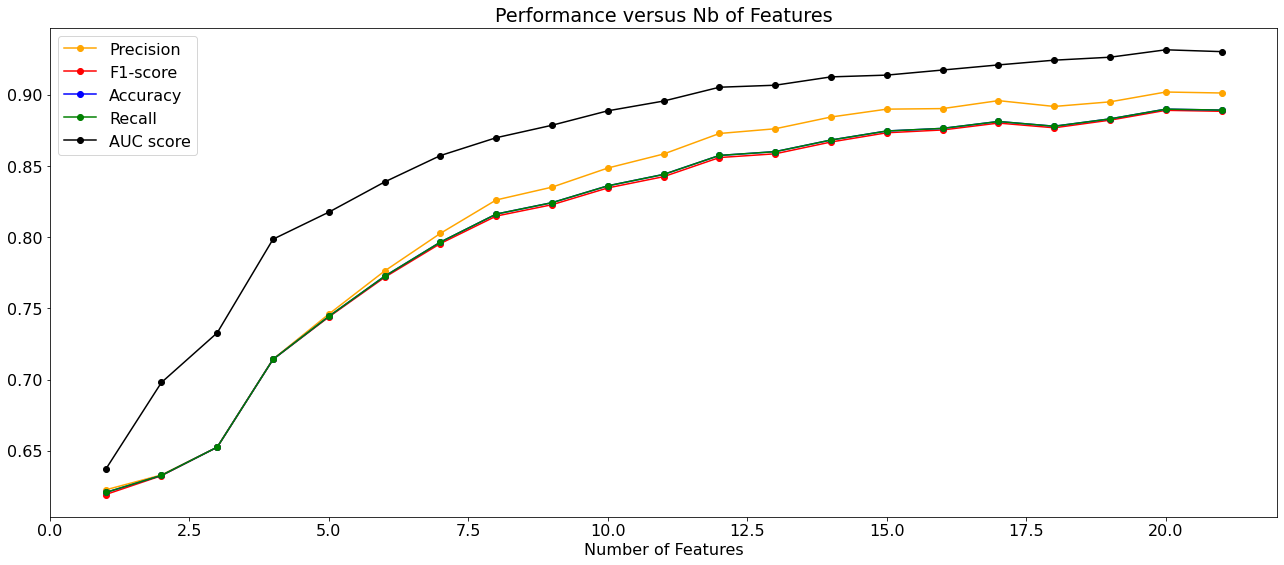

accuracy = 0.891 
precision = 0.903 
recall = 0.891 
f1 = 0.890 
AUC score = 0.932
-----------------------------------------------------------------------



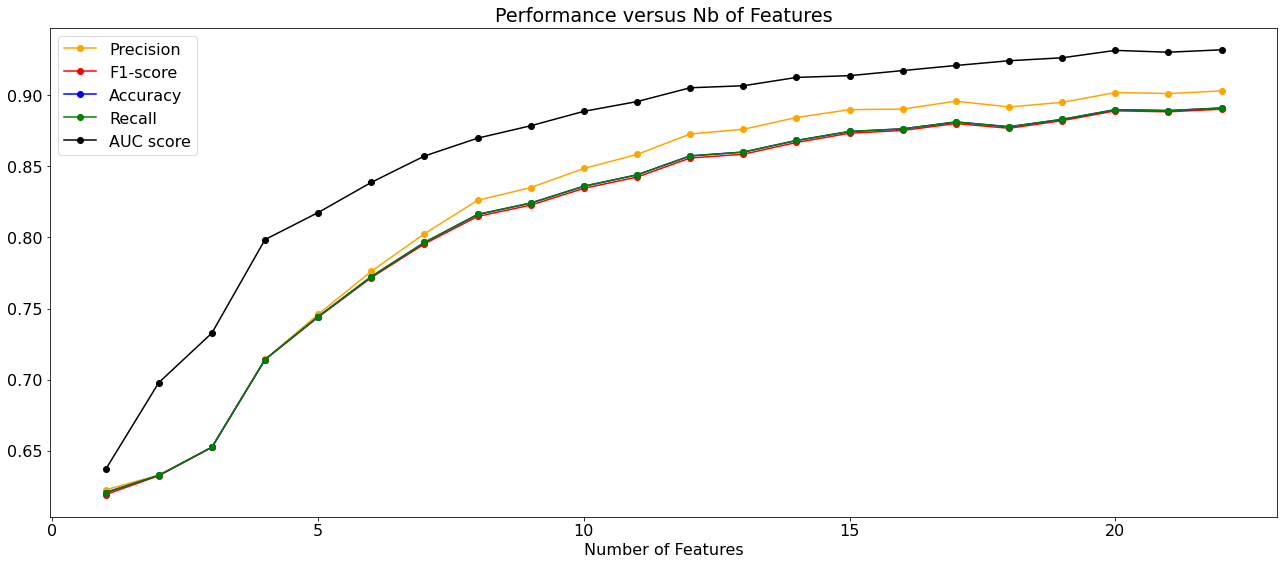

accuracy = 0.890 
precision = 0.901 
recall = 0.890 
f1 = 0.889 
AUC score = 0.933
-----------------------------------------------------------------------



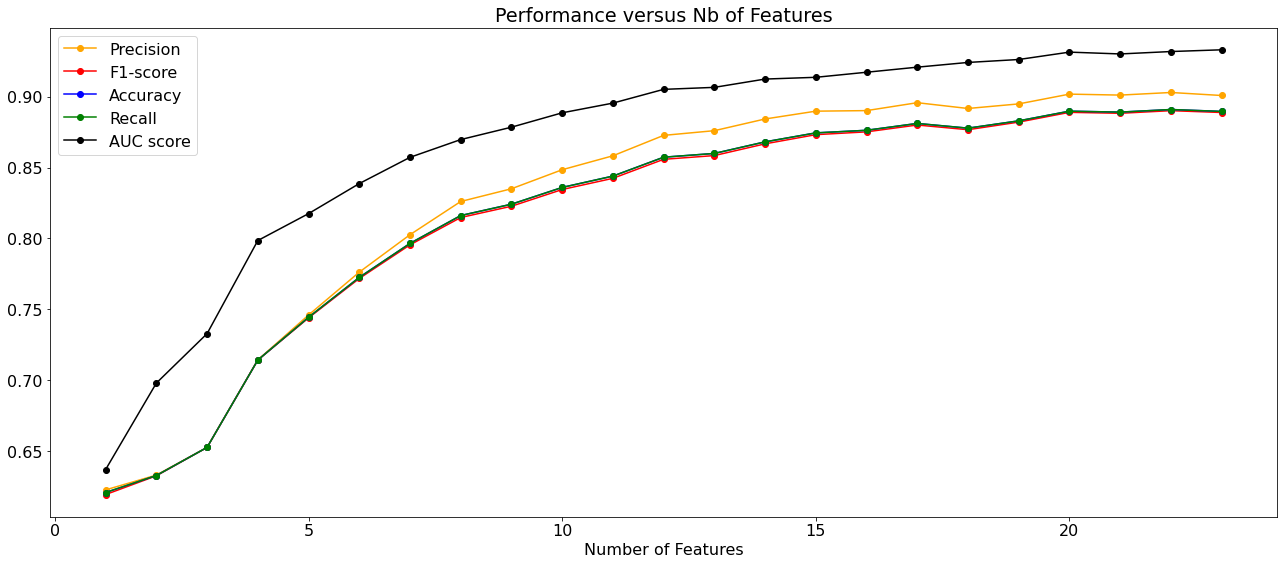

accuracy = 0.887 
precision = 0.899 
recall = 0.887 
f1 = 0.887 
AUC score = 0.932
-----------------------------------------------------------------------



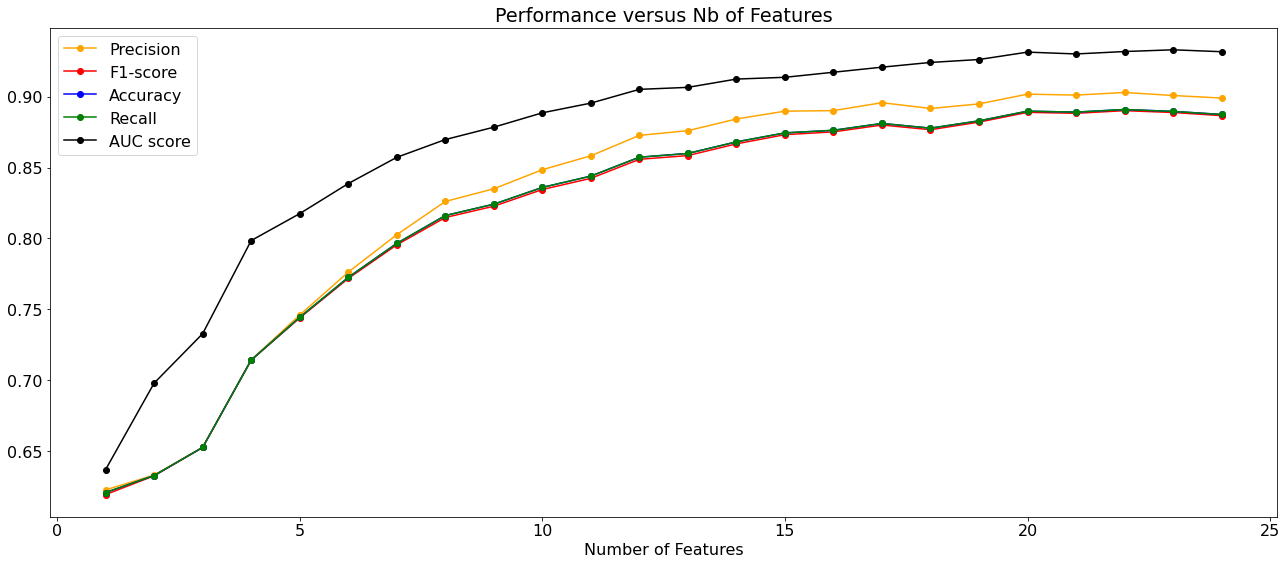

accuracy = 0.888 
precision = 0.900 
recall = 0.888 
f1 = 0.887 
AUC score = 0.932
-----------------------------------------------------------------------



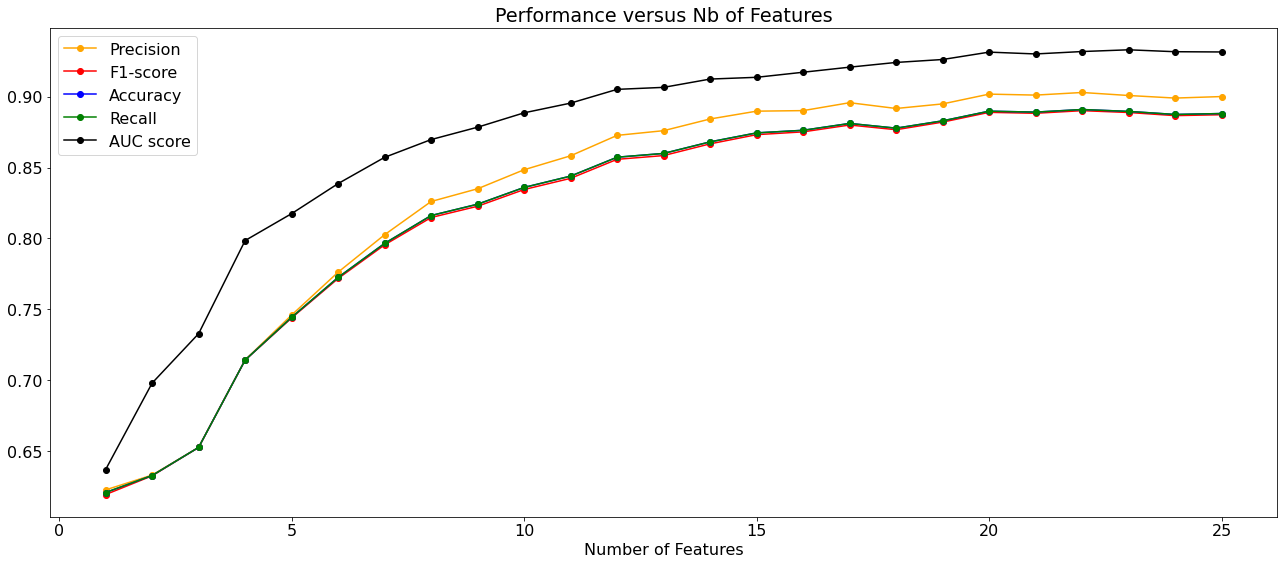

accuracy = 0.887 
precision = 0.899 
recall = 0.887 
f1 = 0.886 
AUC score = 0.931
-----------------------------------------------------------------------



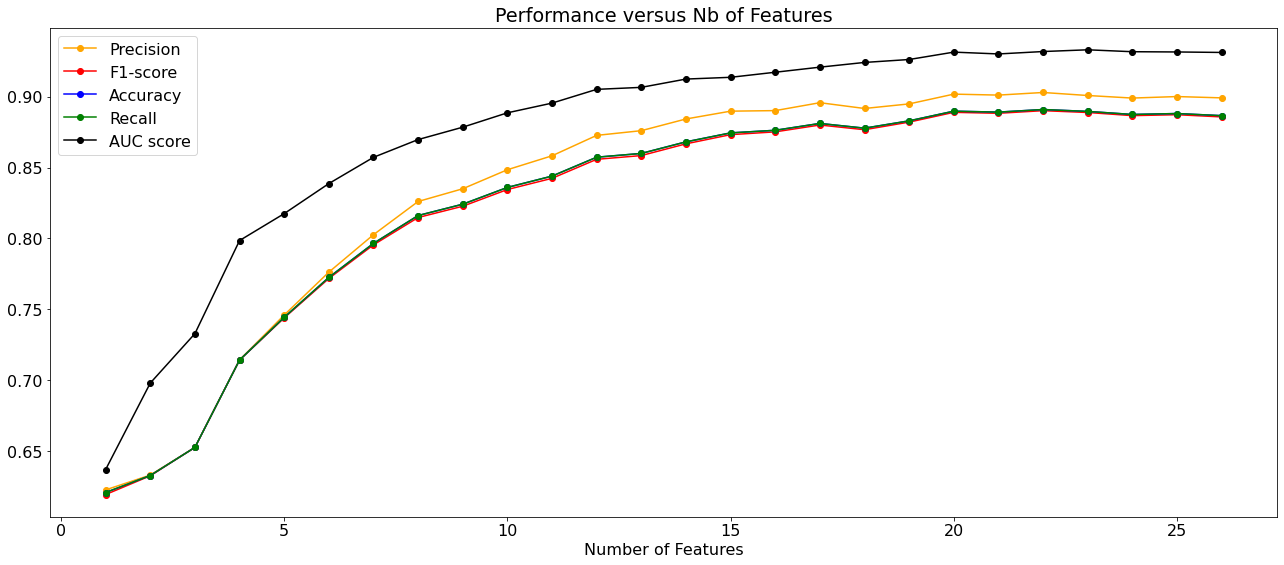

accuracy = 0.888 
precision = 0.900 
recall = 0.888 
f1 = 0.887 
AUC score = 0.931
-----------------------------------------------------------------------



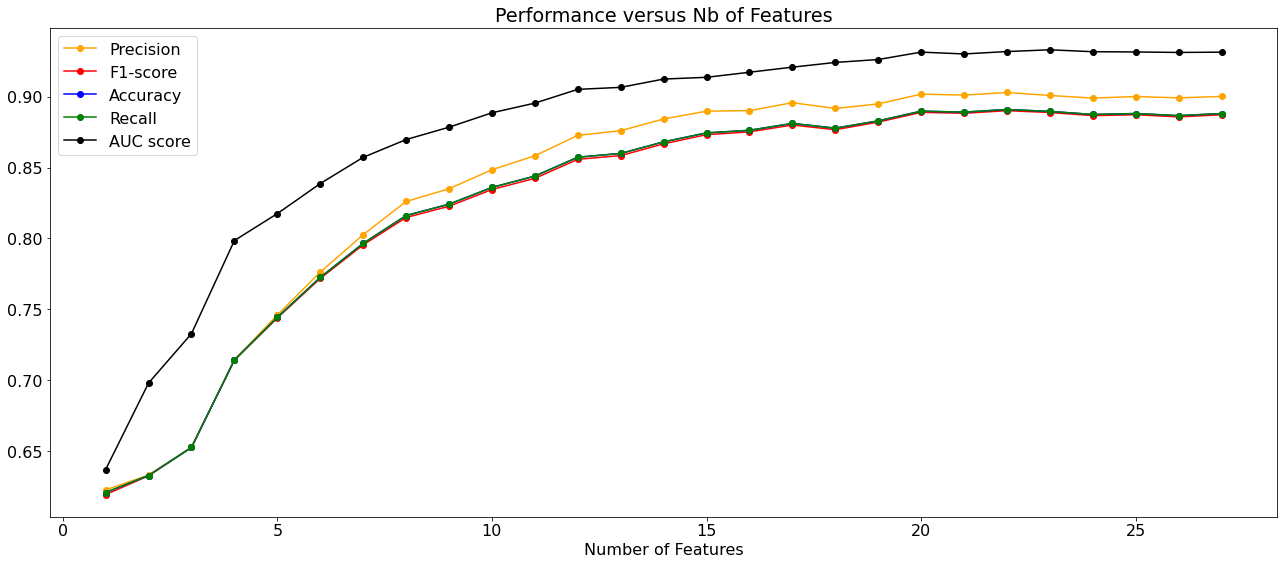

accuracy = 0.886 
precision = 0.898 
recall = 0.886 
f1 = 0.886 
AUC score = 0.934
-----------------------------------------------------------------------



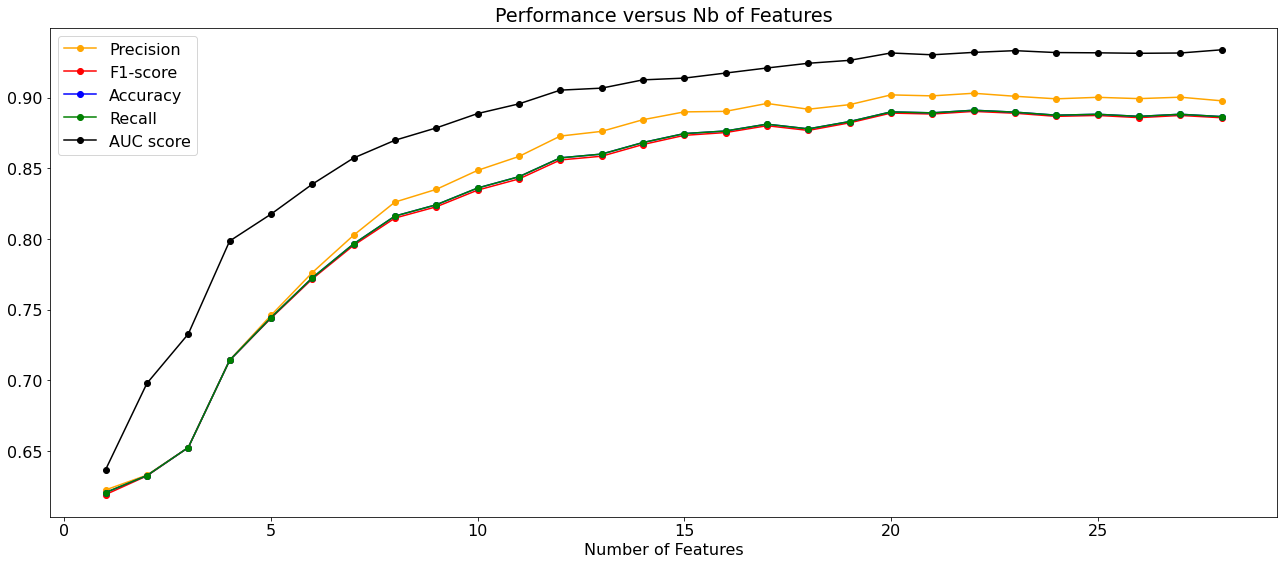

accuracy = 0.887 
precision = 0.899 
recall = 0.887 
f1 = 0.886 
AUC score = 0.931
-----------------------------------------------------------------------



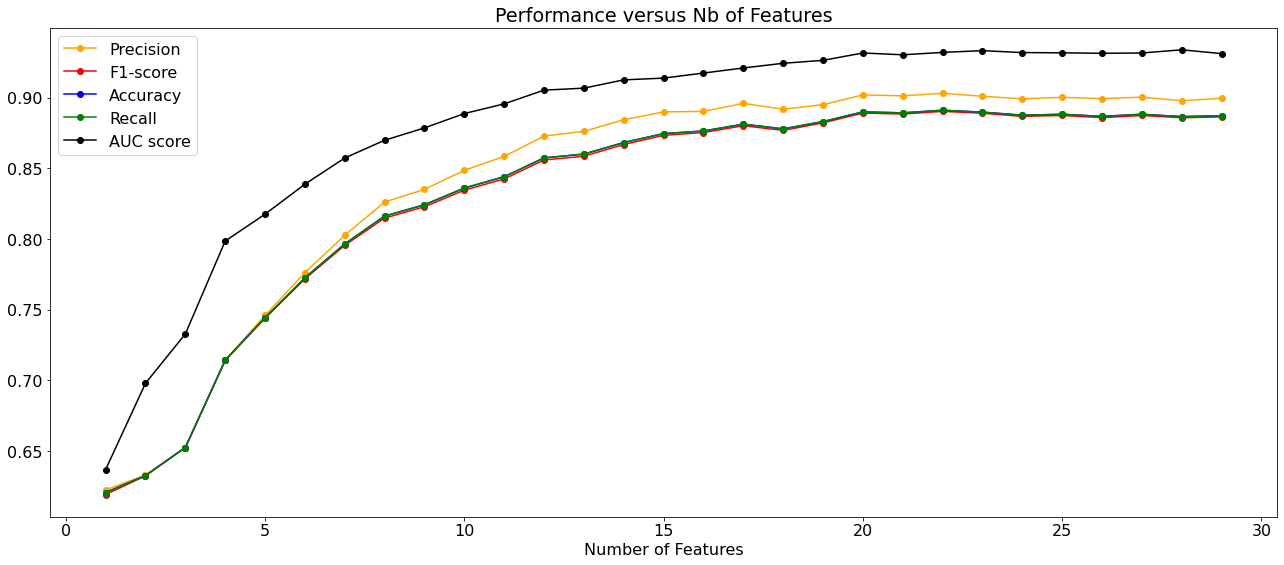

accuracy = 0.883 
precision = 0.895 
recall = 0.883 
f1 = 0.882 
AUC score = 0.930
-----------------------------------------------------------------------



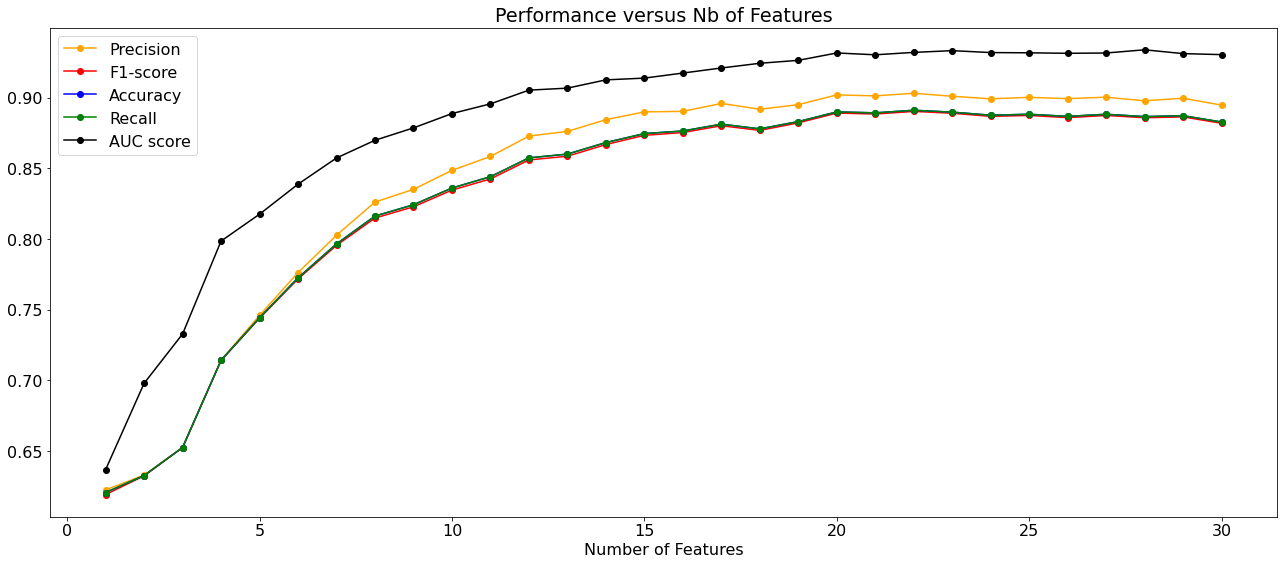

accuracy = 0.883 
precision = 0.895 
recall = 0.883 
f1 = 0.883 
AUC score = 0.931
-----------------------------------------------------------------------



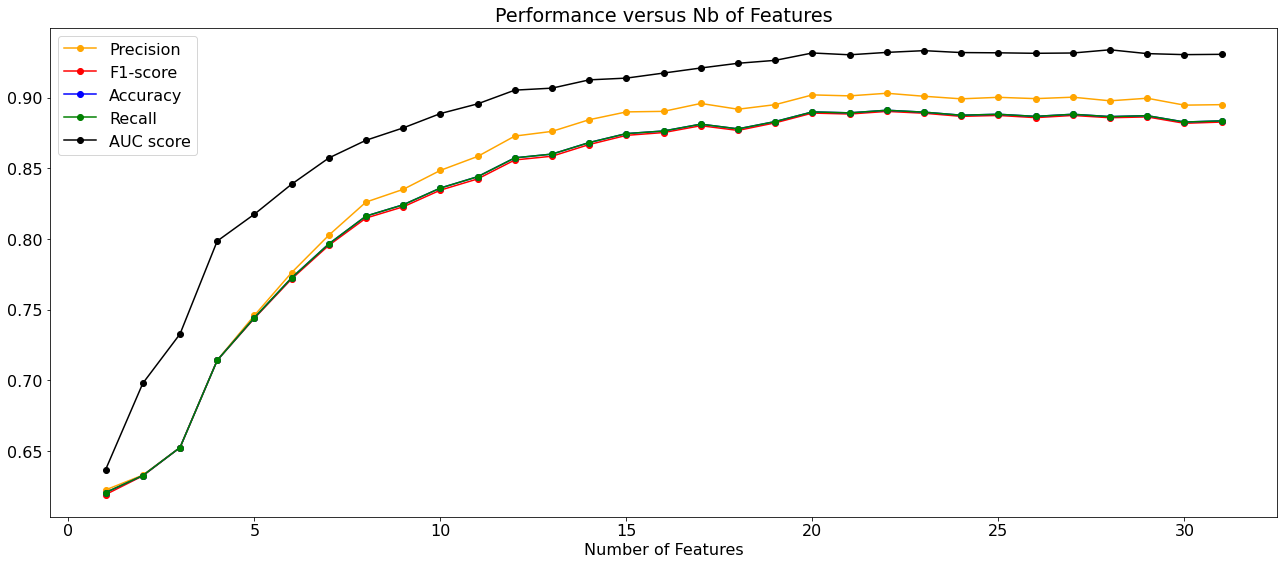

accuracy = 0.882 
precision = 0.893 
recall = 0.882 
f1 = 0.881 
AUC score = 0.929
-----------------------------------------------------------------------



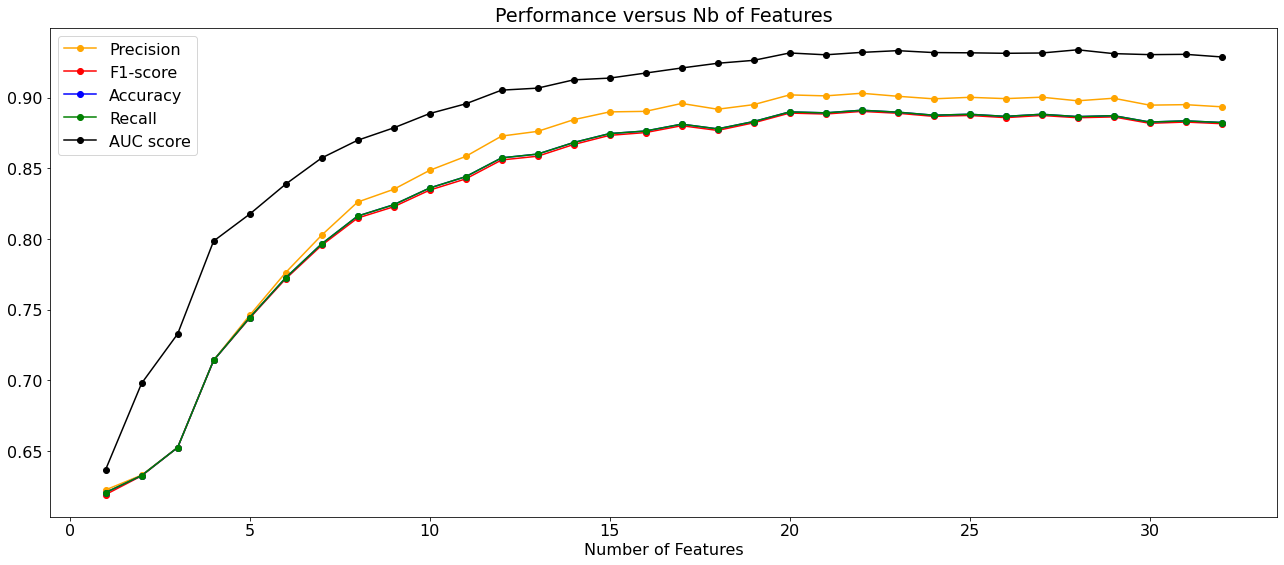

accuracy = 0.884 
precision = 0.895 
recall = 0.884 
f1 = 0.883 
AUC score = 0.931
-----------------------------------------------------------------------



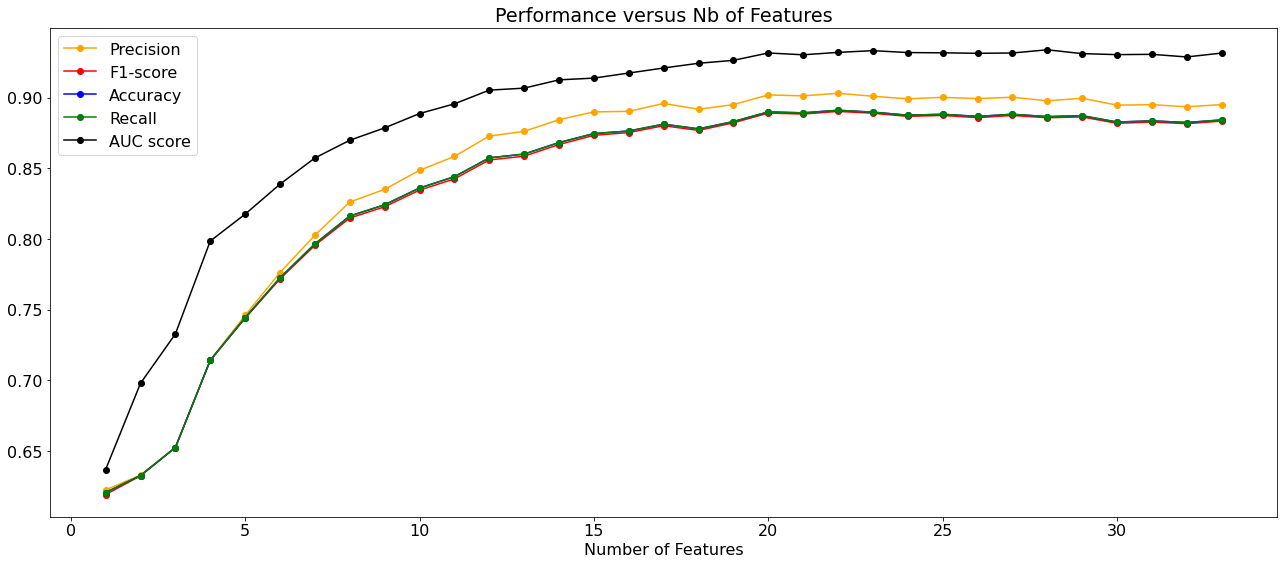

accuracy = 0.880 
precision = 0.893 
recall = 0.880 
f1 = 0.880 
AUC score = 0.931
-----------------------------------------------------------------------



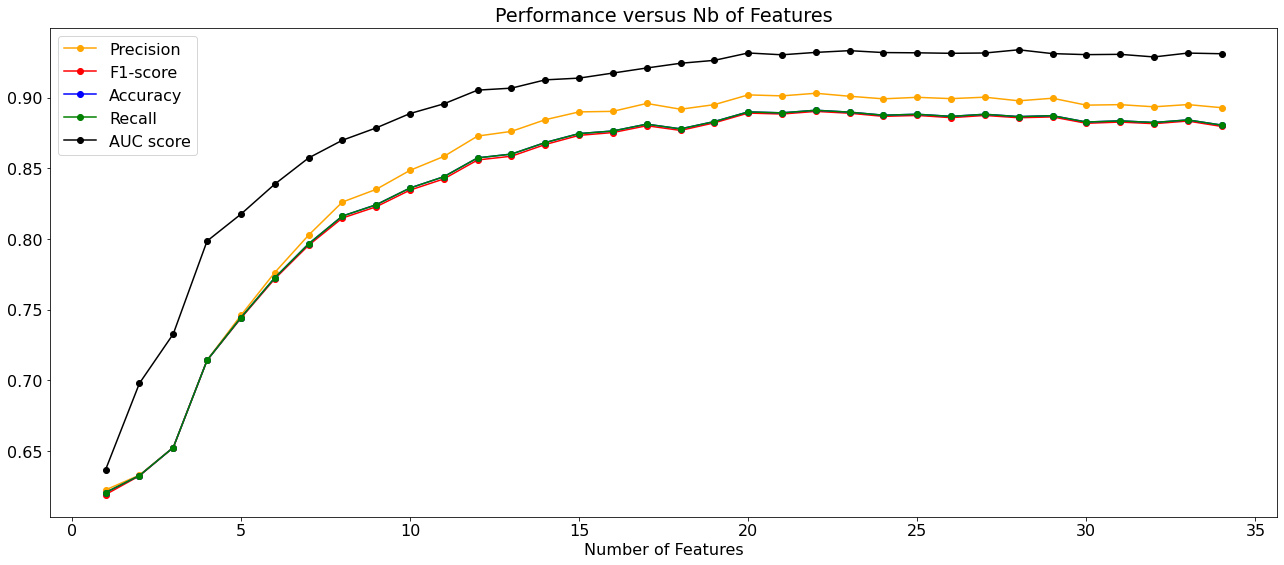

Highest Accuracy:  0.891
Index of highest Accuracy   22
Highest Precision:  0.9030154119323712
Nb of features  of highest Precision  22
Highest Recall:  0.891
Nb of features  of highest Recall     22
Highest F1:  0.8901814737153666
Nb of features  of highest F1         22
Highest AUC score:  0.9337526666666666
Nb of features of highest AUC score  28


In [50]:

# min nb of feat to start the search from
xmin=1
# max nb of feat to stop the search at
xmax=35
# loop over the a range of number of features up until xmax with a step to increase speed
step = 1

    
featBestNumber2 = searchBestNumber(xmin, xmax, step,X_for_embedded, y, indices2)

#########################################################
# write to disk dataframe with best number of freatures
#########################################################

# X.iloc[:, indices[:ind]].to_feather(r"D:\DataSet\TfIdf\D2-best"+str(featBestNumber2)+".feather")
    
#         print("nb features: " + str(i)+"\n")
#         print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))


## 2.3 Verify most important features from Random Forest

In [84]:
# slice dataset with the best performing number of features
XRound3=X2.iloc[:,indices2[:featBestNumber2]]
X_train, X_test, y_train, y_test = train_test_split(XRound3, y, test_size=0.1, random_state=42, stratify=y)
clf = RandomForestClassifier(random_state=10,verbose=1,n_jobs=-1).fit(X_train,y_train)
y_pred = clf.predict(X_test)

y_prob = clf.predict_proba(X_test)[:, 1]

accuracy, precision, recall, f1, auc = get_metrics(y_test, y_pred,y_prob)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f \nAUC score = %.3f" % (accuracy, precision, recall, f1,auc))
print("-----------------------------------------------------------------------\n")


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


accuracy = 0.886 
precision = 0.898 
recall = 0.886 
f1 = 0.885 
AUC score = 0.932
-----------------------------------------------------------------------



## 2.3 Test Performances on three algos after second round of Feature selection

In [ ]:
benchmarkAlgos(X_for_embedded, y)

# GridSearch for Hyp-Tuning on selected features


In [91]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
X_train, X_test, y_train, y_test = train_test_split(XRound3, y, test_size=0.1, random_state=42, stratify=y)
forest = RandomForestClassifier(random_state=10, verbose=0,n_jobs=-1)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_estimators = [100, 300, 500]
max_depth = [5, 8, 15]
min_samples_split = [2, 5, 10, 100]
min_samples_leaf = [1, 2, 5, 10] 
bootstrap = [True, False]
hyperF = dict(n_estimators = n_estimators, 
              max_depth = max_depth,  
              min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf,
              bootstrap=bootstrap)
print(hyperF)
gridF = RandomizedSearchCV (forest, hyperF, cv = cv, verbose = 2, n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

{'n_estimators': [100, 300, 500], 'max_depth': [5, 8, 15], 'min_samples_split': [2, 5, 10, 100], 'min_samples_leaf': [1, 2, 5, 10], 'bootstrap': [True, False]}
Fitting 30 folds for each of 10 candidates, totalling 300 fits


In [ ]:
# write best model to disk 
with open('./Data/D2-RF-BEST-MODEL','wb') as model:
    pickle.dump(bestF, model)

# read from disk best model
# with open('./Data/D2-RF-BEST-MODEL','rb') as model:
#     bestF = pickle.load(model)


accuracy = 0.892 
precision = 0.907 
recall = 0.892 
f1 = 0.891 
AUC score = 0.933
-----------------------------------------------------------------------

score 0.892


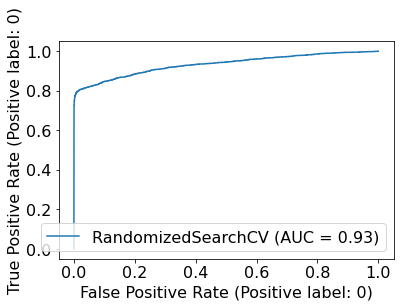

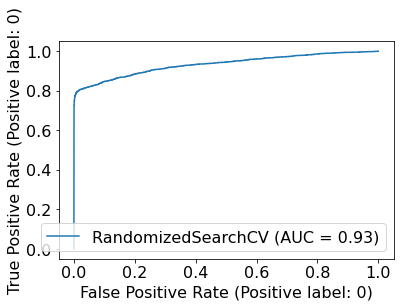

In [96]:
y_pred = bestF.predict(X_test)

y_prob = bestF.predict_proba(X_test)[:, 1]
plot_roc_curve(bestF,X_test,y_test, pos_label='0')

accuracy, precision, recall, f1, auc = get_metrics(y_test, y_pred,y_prob)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f \nAUC score = %.3f" % (accuracy, precision, recall, f1,auc))
print("-----------------------------------------------------------------------\n")

plot_roc_curve(bestF,X_test,y_test, pos_label='0')
score = bestF.score(X_test, y_test)
print("score {:.3f}".format(score))

## Logistic Regression Hyper tuning

In [105]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 30 folds for each of 10 candidates, totalling 300 fits


C:\Users\Bassem new\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.62245679 0.69585802        nan        nan        nan 0.62430247
 0.62215432        nan        nan        nan]
  warnings.warn(
C:\Users\Bassem new\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Best Score: 0.695858024691358
Best Hyperparameters: {'solver': 'newton-cg', 'penalty': 'none', 'C': 1e-05}


In [ ]:
y_pred = grid_result.predict(X_test)

y_prob = grid_result.predict_proba(X_test)[:, 1]

accuracy, precision, recall, f1, auc = get_metrics(y_test, y_pred,y_prob)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f \nAUC score = %.3f" % (accuracy, precision, recall, f1,auc))
print("-----------------------------------------------------------------------\n")


score = grid_result.score(X_test, y_test)
print("score {:.3f}".format(score))